# Advance NLP: Hate Speech detection using Transformers (Deep Learning)

## Using Pytorch and SageMaker

_Deep Learning Project_

-------

**Problem Statement**

The term hate speech is understood as any type of verbal, written or behavioural communication that attacks or uses derogatory or discriminatory language against a person or group based on what they are, in other words, based on their religion, ethnicity, nationality, race, colour, ancestry, sex or another identity factor. In this problem, We will take you through a hate speech detection model with Machine Learning and Python.

Hate Speech Detection is generally a task of sentiment classification. So for training, a model that can classify hate speech from a certain piece of text can be achieved by training it on a data that is generally used to classify sentiments. So for the task of hate speech detection model, We will use the Twitter tweets to identify tweets containing Hate speech.

----

## Project Outline

The general outline of the project is divided into important major section in which each of the section is equally important to the project. They are outlined as follows.

1. Downloading the data
2. Preparing and Preprocessing the data
3. Data Visualization
4. Transform the data
5. Model development 
6. Training and Validation
7. Model Inference
8. Amazon SageMaker Deployment

We will follow this project outline with needed modifications. 

The data is downloaded from the kaggle, preprocessed and transformed using Pytorch library. The transformer model is developed using links prvided in the model building section and the research paper "Attention is all you need".

The training and validation is carried out, the trained model is saved in the directory and test dataset is predicted and model inference is also made using the saved model.

The training and validation is again done via Amazon SageMaker and the trained model is deployed.

## Step 1: Downloading the data

For the model that we are going to built, we will download the dataset from the kaggle website using the link https://www.kaggle.com/vkrahul/twitter-hate-speech?select=train_E6oV3lV.csv

We express our gratitude to Mr. Rahul Agarwal for creating this dataset.

In [96]:
pip install opendatasets 

     |████████████████████████████████| 58 kB 9.4 MB/s  eta 0:00:01
     |████████████████████████████████| 78 kB 4.0 MB/s  eta 0:00:01
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73053 sha256=cc35833cb5b06fb6703d222212136e7f09479c1718f12cdb7cf098a9adf38a6a
  Stored in directory: /home/ec2-user/.cache/pip/wheels/77/47/e4/44a4ba1b7dfd53faaa35f59f1175e123b213ff401a8a56876b
Successfully built kaggle
Note: you may need to restart the kernel to use updated packages.


In [97]:
import opendatasets as od
train_tweets = od.download("https://www.kaggle.com/vkrahul/twitter-hate-speech?select=train_E6oV3lV.csv")

Skipping, found downloaded files in "./twitter-hate-speech" (use force=True to force download)


## Step 2: Preparing and Preprocessing the data

**Preprocessing** the data is very important in Natural Language Processing (NLP) as the incoming textual data can contain noise in large amounts. For this part we will use regex, beautifulsoup libraries to remove any html parser present and any unwanted symbols.

In [189]:
#import the required libraries
import pandas as pd
import numpy as np
import re
from bs4 import BeautifulSoup

def review_to_words(review):
    '''Function that takes in the word and remove html parser and other symbols.
    Args: review, the sentence in the string format
    returns: cleansed text'''
    text = BeautifulSoup(review, "html.parser").get_text() # Remove HTML tags
    text = re.sub(r"[^a-zA-Z0-9]", " ", text.lower()) # Convert to lower case
    return text

def read_csv(file_path):
    '''Function that takes in the file and returns in the format cleaned and ready for feature learning
    Args: csv file
    returns: datarfame'''
    df = pd.read_csv(file_path)          #read in the file
    df = df.drop(['id'], axis=1)         #drop the unecessary columns
    df['tweet'] = df['tweet'].apply(lambda x:review_to_words(x))   #apply the above funtion to preporcess the word
    df = df[['tweet','label']]            #rearrange the columns
    return df       #returns dataframe

#Now, specify the path that file located
path = r'/home/ec2-user/SageMaker/twitter-hate-speech/train_E6oV3lV.csv'

#apply the function and view the dataframe
df = read_csv(path)
df.head()    

,tweet,label
0,user when a father is dysfunctional and is s...,0
1,user user thanks for lyft credit i can t us...,0
2,bihday your majesty,0
3,model i love u take with u all the time in ...,0
4,factsguide society now motivation,0


The above dataframe tells us, it is preprocessed properly and ready for feature learning.

In [3]:
df.describe()

,label
count,31962.000000
mean,0.070146
std,0.255397
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


### Remove local mistyped english words with thier correct english words

There are local unofficial words  which mean the same meaning in english but been adopted to local writing system. Basically a lazy way of writing the words in thier own. Some recognizable are put through this dict. Upon improving this dictionary will be helpful in future for better results.

In [190]:
#Code for removing mistake words
replace_words = {'luv':'love','wud':'would','lyk':'like','wateva':'whatever','ttyl':'talk to you later',
               'kul':'cool','fyn':'fine','omg':'oh my god!','fam':'family','bruh':'brother',
               'cud':'could','fud':'food'} ## Need a huge dictionary

#we will pass a sentence to test our function
sentence = "I luv myself"
words = sentence.split()    #split the sentence into words

#replace the words in the sentence with the word in the dictionary if the the actual word itself.
reformed = [replace_words[word] if word in replace_words else word for word in words]
reformed = " ".join(reformed)    #join the splitted after reforming
print(reformed)     #print the reformed

I love myself


The above function worked and the word 'luv' ir replaced by 'love' from the dictionary. As I said, improving this dictionary will help us improve the end results.

#### Now let us apply this dictionary in our table and get it reformed.

In [191]:
#apply the function on df['tweet']
df['tweet'] = df['tweet'].apply(lambda x : ' '.join(replace_words[word] if word in replace_words else word for word in x.split()))

#disply the reformed
df.head()

,tweet,label
0,user when a father is dysfunctional and is so ...,0
1,user user thanks for lyft credit i can t use c...,0
2,bihday your majesty,0
3,model i love u take with u all the time in ur,0
4,factsguide society now motivation,0


## Step 3: Data Visualization 

   In this section, we will do simple visualization to see the use of words in each with the help of wordcloud library. This will help us if any common words that is not useful the training can be taken away. 

In [4]:
pip install wordcloud

     |████████████████████████████████| 366 kB 23.6 MB/s eta 0:00:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/pytorch_latest_p36/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


Normal words


(-0.5, 799.5, 499.5, -0.5)

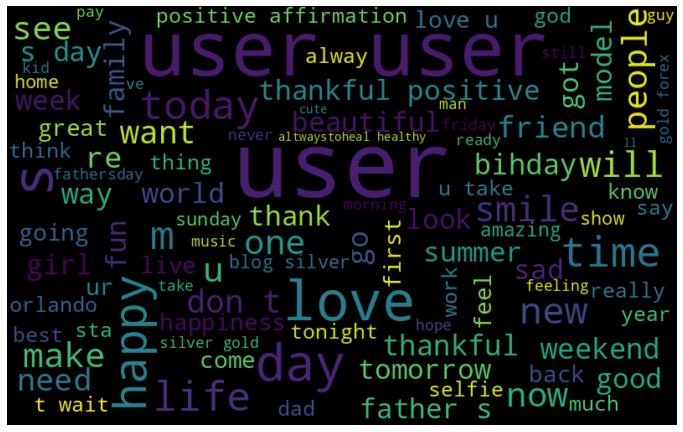

In [5]:
#Import the libraries
from wordcloud import WordCloud
import matplotlib.pyplot as plt 

#take all words in df['tweet'] with the labels 0 for visualization
normal_words = ' '.join([word for word in df['tweet'][df['label'] == 0]])
#set the wordcloud parameters
wordcloud = WordCloud(width = 800, height = 500, max_font_size = 110,max_words = 100).generate(normal_words)
print('Normal words')
#plot the graph
plt.figure(figsize= (12,8))
plt.imshow(wordcloud, interpolation = 'bilinear',cmap='viridis')
plt.axis('off')

Normal words


(-0.5, 799.5, 499.5, -0.5)

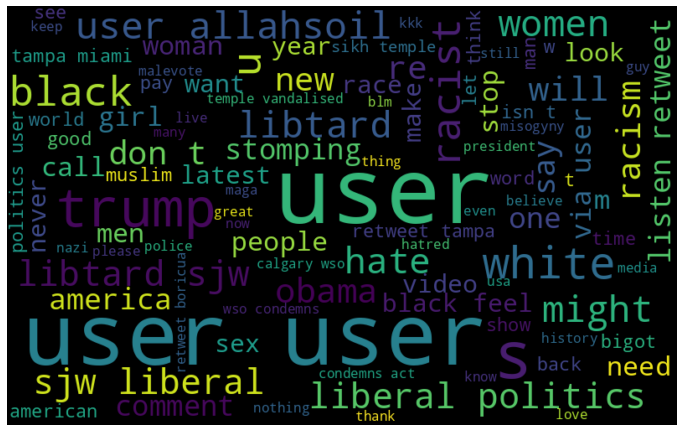

In [6]:
#take all words in df['tweet'] with the labels 1 for visualization
normal_words = ' '.join([word for word in df['tweet'][df['label'] == 1]])
#set the wordcloud parameters
wordcloud = WordCloud(width = 800, height = 500, max_font_size = 110,max_words = 100).generate(normal_words)
print('Normal words')
#plot the figure
plt.figure(figsize= (12,8))
plt.imshow(wordcloud, interpolation = 'bilinear',cmap='viridis')
plt.axis('off')

In the above visuals, the word user comes very often. The word 'user' nothing but it tells this user tweeted this which is not important to the training as it can infer different meaning wrongly. Therefore, it is good to take down that word.

In [192]:
#replace the word user with empty space
df['tweet'] = df['tweet'].apply(lambda x: x.replace('user',''))

#print the dataframe
df.head()

,tweet,label
0,when a father is dysfunctional and is so self...,0
1,thanks for lyft credit i can t use cause the...,0
2,bihday your majesty,0
3,model i love u take with u all the time in ur,0
4,factsguide society now motivation,0


### Let's see the balance between the labels

0    29720
1     2242
Name: label, dtype: int64


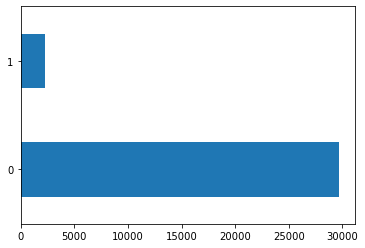

In [8]:
df.label.value_counts().plot(kind='barh')   #bar plot with value counts for each labels
print(df.label.value_counts()) #print it the numbers as well

There is high ***Imbalance*** between the **label 0 and 1**. To tackle this problem, we have many ways to do it. There is two popular ways to this is ***oversampling**** by increase the number tweets with label 1. We can do this with the help of ***SMOTE overspampling technique***. But if we can see, it's approximately 12 times higher than label 1. In our case, upsampling might lead to overfitting in the training.

The another is ***undersampling,*** which is good for this type of problem. The disadvantage in picking them up is we are going to loss so much information in training this model. But upon development, and collection of data in the future and updating the model, this problem can be resolved.

Therefore, we are picking ***undersampling technique*** for this problem and continue our model development and training process.

In [9]:
#print the shape and null counts of the dataframe

print("Shape: ", df.shape)
print("Label null values count: ", df['label'].isna().sum())
print("Tweets null values count: ", df['tweet'].isna().sum())

Shape:  (31962, 2)
Label null values count:  0
Tweets null values count:  0


### Underspampling technique

In [193]:
#divide the dataframe with each class labels
df_positive = df[df['label']==0]
df_negative = df[df['label']==1]

#sample only 2500 out of all from the label 0
df_positive = df_positive.sample(2500)

#append the df with label 1 with label 0
df_positive  = df_positive.append(df_negative)

#Shuffle the df
from sklearn.utils import shuffle
df = shuffle(df_positive)

#reset the index
df = df.reset_index(drop=True)
df.head()

,tweet,label
0,cont day 3 of 4 d dl2016 downloadfestival meta...,0
1,aymtracklist no seasoned aist vocals kahik chi...,0
2,mcconnell obstruction goes all the way back t...,1
3,stop teasing us with these pics i m not slee...,0
4,the reason is said to be mr perfectionist is ...,0


In [194]:
#print the label counts and see how many are there

print("The label counts: ", df.label.value_counts())

The label counts:  0    2500
1    2242
Name: label, dtype: int64


In [195]:
# we will write this file into the csv file and can read it later to save memory
df.to_csv('train/df.csv')
del df

With this, the data preparation and preprocessing techniques are completed. Now we will move on to transforming the data to feed it to the model.

In [1]:
pip install --upgrade pip

Note: you may need to restart the kernel to use updated packages.


In [1]:
pip install torchtext --no-cache-dir

Note: you may need to restart the kernel to use updated packages.


In [18]:
pip install spacy --no-cache-dir

     |████████████████████████████████| 6.4 MB 15.8 MB/s eta 0:00:01
     |████████████████████████████████| 42 kB 41.3 MB/s eta 0:00:01
     |████████████████████████████████| 10.2 MB 27.8 MB/s eta 0:00:01
     |████████████████████████████████| 622 kB 63.8 MB/s eta 0:00:01
     |████████████████████████████████| 9.8 MB 60.3 MB/s eta 0:00:01
     |████████████████████████████████| 456 kB 70.8 MB/s eta 0:00:01
     |████████████████████████████████| 126 kB 80.7 MB/s eta 0:00:01
     |████████████████████████████████| 58 kB 70.3 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


## Step 4: Transform the data

For the model we are going to construct in this notebook we will construct a feature representation which can the model can take in. We are using the help of torchtext library, which will build vocabularies for tweets and labels. Further tokenize them. Finally, split them into a iterators which can be used for test and validation using BucketIterator. 

The function build_vocab will return the iterators, word_dict contains the word dictionary and the length of the text vocab which can be used in the model.

In [196]:
#Downloading the spacy tokenizer english library before executing the build_vocab function, helps in building the tokenizer. 
#Otherwise, the function build_vocab will throw an error.

from spacy.cli.download import download
download('en_core_web_sm')

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [197]:
#Load the library
spacy.load('en_core_web_sm')

In [198]:
import torch
from torch import nn
from torch.autograd import Variable
import torch.nn.functional as F
import random, tqdm, sys, math, gzip
from torchtext.legacy import data, datasets, vocab
import numpy as np
import random
import spacy


#defining the function to transform the data
def build_vocab(file_path):
    '''Function to take in the preprocessed file and transform into a iterators and word dictionaries
    Args: csv file
    returns: iterators, length of vocab, word_dict'''
    #Reproducing same results
    SEED = 2019

    #Torch
    torch.manual_seed(SEED)
    
    #Instantiate the fields
    TEXT = data.Field(tokenize='spacy',lower=True, include_lengths=True, batch_first=True)
    LABEL = data.LabelField(batch_first=True)
    #since the first column is the index, the tuple is left none 
    fields = [(None,None),('tweet', TEXT),('label', LABEL)]
    
    #load the file and build the torchtext dataset
    training_data=data.TabularDataset(path = file_path,format = 'csv',fields = fields,skip_header = True)
    
    #split the dataset into train and valid
    train_data, valid_data = training_data.split(split_ratio=0.7, random_state = random.seed(SEED))
    
    #build vocabulary
    TEXT.build_vocab(train_data,min_freq=3, vectors = "glove.6B.100d")  
    LABEL.build_vocab(train_data)  

    #check whether cuda is available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  

    #set batch size
    BATCH_SIZE = 64

    #Load an iterator
    train_iterator, valid_iterator = data.BucketIterator.splits(
        (train_data, valid_data), 
        batch_size = BATCH_SIZE,
        sort_key = lambda x: len(x.tweet),
        sort_within_batch=True,
        device = device)
    len_text_vocab = len(TEXT.vocab)
    word_dict = TEXT.vocab.stoi
    #returns the required objects
    return train_iterator, valid_iterator, len_text_vocab, word_dict
   

We will provide the above function with path and in turn get the iterators and word dict.

In [199]:
#defining the path of the file
path = r'/home/ec2-user/SageMaker/train/df.csv'

#assigining it to a function to get iterators
train_it, test_it, len_text_vocab, word_dict = build_vocab(path)

/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torchtext/data/utils.py:123: UserWarning: Spacy model "en" could not be loaded, trying "en_core_web_sm" instead
  warnings.warn(f'Spacy model "{language}" could not be loaded, trying "{OLD_MODEL_SHORTCUTS[language]}" instead')


In [200]:
#get the number of batches in each of the iterators

print(f'- nr. of training examples {len(train_it)}')
print(f'- nr. of testing examples {len(test_it)}')

- nr. of training examples 52
- nr. of testing examples 23


## Step 5: Model Building

Now, that the **feature learning and transforming the data** is done. We have batches of iterators in hand. We will define the model for this problem.

As per the project, this project has to accomplished with the help of the Tranformers.Transformers are a very exciting family of machine learning architectures.

As a prerequisitie, basic understanding of **neural networks, back propagation, feed forward and a working knowledge of pytorch** will help in building this model.

To learn more about how this model build from scratch, resources from the following links,

The first ever research paper on Transformer called ***'Attention Is All You Need'*** by the employees of google.
https://papers.nips.cc/paper/2017/file/3f5ee243547dee91fbd053c1c4a845aa-Paper.pdf

A blog and youtube channel by Peter Bloem
http://peterbloem.nl/blog/transformers , https://www.youtube.com/playlist?list=PLIXJ-Sacf8u60G1TwcznBmK6rEL3gmZmV

The Attention model from the students of Harvard university,
https://nlp.seas.harvard.edu/2018/04/03/attention.html

The provided above links are phenomenal and without which understanding and build such complicated architectures wouldn't become possible. 


On a higher level, we will build a basic self attention model, which is the core the classification model, which assigns each token into the three famous variables called key, query and value. The transformer block carries the self-attention layer and the number of blocks built on transformer classifier, that number of self attention modules are carried. Finally the classification Transformer is built to carry these transformer blocks.

In [12]:
#Import libraries
import torch
from torch import nn
import torch.nn.functional as F

import random, math, sys

#set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  

#Basic self attention model
class SelfAttention(nn.Module):
    """
    Basic Self Attention module, Heart of transormer
    Args: nn.Module from Pytorch
    """

    def __init__(self, emb, heads=8, mask=False):
        """
        emb: Embedding dimension
        heads: 8, as in emb are divided on heads and trained parallel
        mask: masking is done on seq-to-seq models, but it is kept here for future model development
        """

        super().__init__()        #inherit the pytorch

        assert emb % heads == 0, f'Embedding dimension ({emb}) should be divisible by nr. of heads ({heads})'

        self.emb = emb       #embedding dimensions
        self.heads = heads   #number of heds to split the job
        self.mask = mask     #masking if needed

        s = emb // heads
        # - We will break the embedding into `heads` chunks and feed each to a different attention head

        self.tokeys    = nn.Linear(emb, emb, bias=False)
        self.toqueries = nn.Linear(emb, emb, bias=False)
        self.tovalues  = nn.Linear(emb, emb, bias=False)

        self.unifyheads = nn.Linear(emb, emb)

    def forward(self, x):

        b, t, e = x.size()
        h = self.heads
        assert e == self.emb, f'Input embedding dim ({e}) should match layer embedding dim ({self.emb})'

        s = e // h

        keys    = self.tokeys(x)
        queries = self.toqueries(x)
        values  = self.tovalues(x)

        keys    = keys.view(b, t, h, s)
        queries = queries.view(b, t, h, s)
        values  = values.view(b, t, h, s)

        # -- We first compute the k/q/v's on the whole embedding vectors, and then split into the different heads.
        #    See the following video for an explanation: https://youtu.be/KmAISyVvE1Y

        # Compute scaled dot-product self-attention

        # - fold heads into the batch dimension
        keys = keys.transpose(1, 2).contiguous().view(b * h, t, s)
        queries = queries.transpose(1, 2).contiguous().view(b * h, t, s)
        values = values.transpose(1, 2).contiguous().view(b * h, t, s)

        queries = queries / (e ** (1/4))
        keys    = keys / (e ** (1/4))
        # - Instead of dividing the dot products by sqrt(e), we scale the keys and values.
        #   This should be more memory efficient

        # - get dot product of queries and keys, and scale
        dot = torch.bmm(queries, keys.transpose(1, 2))

        assert dot.size() == (b*h, t, t)

        if self.mask: # mask out the upper half of the dot matrix, excluding the diagonal
            mask_(dot, maskval=float('-inf'), mask_diagonal=False)

        dot = F.softmax(dot, dim=2)
        # - dot now has row-wise self-attention probabilities

        # apply the self attention to the values
        out = torch.bmm(dot, values).view(b, h, t, s)

        # swap h, t back, unify heads
        out = out.transpose(1, 2).contiguous().view(b, t, s * h)

        return self.unifyheads(out)
    
class TransformerBlock(nn.Module):
    '''Transfomer Block are modules that carry self-attention modules, based on the number of 
    blocks needed on the main module, it is build that number of times and the data are fed into the 
    each of the blocks and concatenated at the end'''

    def __init__(self, emb, heads, mask, seq_length, ff_hidden_mult=4, dropout=0.0, attention_type='default', pos_embedding=None):
        super().__init__()

        if attention_type == 'default':
            self.attention = SelfAttention(emb, heads=heads, mask=mask)
        self.mask = mask

        self.norm1 = nn.LayerNorm(emb)
        self.norm2 = nn.LayerNorm(emb)

        self.ff = nn.Sequential(

            nn.Linear(emb, ff_hidden_mult * emb),
            nn.ReLU(),
            nn.Linear(ff_hidden_mult * emb, emb)
        )

        self.do = nn.Dropout(dropout)

    def forward(self, x):

        attended = self.attention(x)

        x = self.norm1(attended + x)

        x = self.do(x)

        fedforward = self.ff(x)

        x = self.norm2(fedforward + x)

        x = self.do(x)

        return x
    
class CTransformer(nn.Module):
    """
    Transformer for classifying sequences
    """

    def __init__(self, emb, heads, depth, seq_length, num_tokens, num_classes, max_pool=True, dropout=0.0, wide=False):
        """
        emb: Embedding dimension
        heads: nr. of attention heads
        depth: Number of transformer blocks
        seq_length: Expected maximum sequence length
        num_tokens: Number of tokens (usually words) in the vocabulary
        num_classes: Number of classes.
        max_pool: If true, use global max pooling in the last layer. If false, use global
                         average pooling.
        """
        super().__init__()

        self.num_tokens, self.max_pool = num_tokens, max_pool

        self.token_embedding = nn.Embedding(embedding_dim=emb, num_embeddings=num_tokens)
        self.pos_embedding = nn.Embedding(embedding_dim=emb, num_embeddings=seq_length)

        tblocks = []
        for i in range(depth):
            tblocks.append(
                TransformerBlock(emb=emb, heads=heads, seq_length=seq_length, mask=False, dropout=dropout))

        self.tblocks = nn.Sequential(*tblocks)

        self.toprobs = nn.Linear(emb, num_classes)

        self.do = nn.Dropout(dropout)

  
   
    def forward(self, x):
        """
        x: A batch by sequence length integer tensor of token indices.
        return: predicted log-probability vectors for each token based on the preceding tokens.
        """
        tokens = self.token_embedding(x)
        b, t, e = tokens.size()

        positions = self.pos_embedding(torch.arange(t, device=device))[None, :, :].expand(b, t, e)
        
        x = tokens + positions
        x = self.do(x)
        x = self.tblocks(x)
        x = x.max(dim=1)[0] if self.max_pool else x.mean(dim=1) # pool over the time dimension
        x = self.toprobs(x)

        return F.log_softmax(x, dim=1)

## Step 6: Training and Validation.

Training the model and validating or testing the model will be done on the same loop. At the end of this function, based on the number of epochs, the training and testing is done at the same time and the evaluation metrics which is accuracy is compared.

We will do this training on two ways possibly.

First on the Jupyter Notebook itself and save the model in it's directory and load the model for Inference.
Secondly, we will train the model on sage maker and deploy it on the sagemaker and look for accuracy metrics.

In [211]:
# defining a function for train loop
def train(train_loader, test_loader, num_epoch, opt):
    '''The function that takes in the iterator, number of epochs and optimizer and return the 
    classification loss andaccuracy metrics.
    Args: Train and test iterator, number of epochs, optimzer
    returns: predicted labels, actual labels'''
    seen = 0
    #initialize every epoch 
    epoch_loss = 0
    total, correction= 0.0, 0.0

    for e in range(num_epoch):     #in the range of epochs specified
        print(f'\n epoch {e}')     #print the nth of epoch
        #train the model
        model.train(True)
        #load the batch
        for batch in tqdm.tqdm(train_loader):
            opt.zero_grad()
            #specify the input and label
            input = batch.tweet[0]
            label = batch.label
            #send the input tensors to the model
            out = model(input)
            #get the result
            output = out.argmax(dim=1)
            #calculate the loss function
            loss = F.nll_loss(out, label)
            loss.backward()
            opt.step()
            seen += input.size(0)
            #loss and accuracy
            total += float(input.size(0))
            correction += float((label == output).sum().item())
            epoch_loss += loss.item()
            print('classification/train-loss', float(loss.item()), seen)
        accuracy = correction / total
        print(f'-- {"training validation"} accuracy {accuracy*100}')    
    
        with torch.no_grad():

            model.train(False)  #model train not needed
            tot, cor= 0.0, 0.0  #metrics for calculating the accuracy
            collect_pred=[]     #list the collectiong the prediction labels
            collect_label=[]    #list for the actual labels

            for batch in tqdm.tqdm(test_it):

                input = batch.tweet[0]
                label = batch.label
                out = model(input).argmax(dim=1)
                
                collect_pred.append(out.cpu().detach().numpy())   #append the prediction to the list
                collect_label.append(label.cpu().detach().numpy())  #append the actual label to the list
                tot += float(input.size(0))                         #total from the input
                cor += float((label == out).sum().item())           #the correct ones
 
            acc = cor / tot    #accuracy
            print(f'-- {"test validation"} accuracy {acc*100}')
    torch.save(model.state_dict(), 'saved_weights2.pt')    #save the model
    print("The model is saved")
    pred, label = list(collect_pred), list(collect_label)  #put the np arrays of prediction and label into the list
    pred, label = np.concatenate(pred, axis=0), np.concatenate(label, axis=0)  #concatenate all the arrays
    return pred, label    #return the prediction and labels for the evaluation
    pass


The train and test loop is defined above. Now, we will set up the hyperparameters for the model and start training on the Jupyter notebook.

In [212]:
#setup the hyperparameters:
emb=128
heads=8
depth = 6
seq_length = 512
num_tokens = len_text_vocab
NUM_CLS = 2

#BUild the model
model = CTransformer(emb=emb, 
                    heads=heads, 
                    depth=depth, 
                    seq_length=seq_length, 
                    num_tokens=num_tokens, 
                    num_classes=NUM_CLS, 
                    max_pool=True)
if torch.cuda.is_available():
    model.cuda()
#push to cuda if available
opt = torch.optim.Adam(lr=0.0001, params=model.parameters())

In [213]:
#call the train loop
pred, label = train(train_it,test_it, 20, opt)


 epoch 0


  0%|          | 0/52 [00:00<?, ?it/s]

classification/train-loss 0.7158622145652771 64


  4%|▍         | 2/52 [00:00<00:05,  9.19it/s]

classification/train-loss 0.8638011813163757 128


  8%|▊         | 4/52 [00:00<00:04,  9.88it/s]

classification/train-loss 0.6543326377868652 192
classification/train-loss 0.7363427877426147 256
classification/train-loss 0.6872543692588806 320


 12%|█▏        | 6/52 [00:00<00:04, 10.44it/s]

classification/train-loss 0.6855265498161316 384
classification/train-loss 0.7084497213363647 448


 15%|█▌        | 8/52 [00:00<00:04, 10.53it/s]

classification/train-loss 0.6476889848709106 512
classification/train-loss 0.8384298086166382 576


 19%|█▉        | 10/52 [00:01<00:04,  9.67it/s]

classification/train-loss 0.6831005215644836 640


 21%|██        | 11/52 [00:01<00:04,  9.00it/s]

classification/train-loss 0.7122406363487244 704


 25%|██▌       | 13/52 [00:01<00:03, 10.65it/s]

classification/train-loss 0.654481828212738 768
classification/train-loss 0.5624980330467224 832
classification/train-loss 0.6887947916984558 896


 29%|██▉       | 15/52 [00:01<00:03, 10.55it/s]

classification/train-loss 0.667921245098114 960
classification/train-loss 0.6304069757461548 1024


 33%|███▎      | 17/52 [00:01<00:03, 10.77it/s]

classification/train-loss 0.6933998465538025 1088


 37%|███▋      | 19/52 [00:01<00:03, 10.73it/s]

classification/train-loss 0.6702424883842468 1152
classification/train-loss 0.6492174863815308 1216
classification/train-loss 0.6651736497879028 1280


 40%|████      | 21/52 [00:02<00:02, 11.19it/s]

classification/train-loss 0.6425343155860901 1344
classification/train-loss 0.6720206141471863 1408


 44%|████▍     | 23/52 [00:02<00:02, 11.00it/s]

classification/train-loss 0.6581149101257324 1472
classification/train-loss 0.8090895414352417 1536


 48%|████▊     | 25/52 [00:02<00:02,  9.97it/s]

classification/train-loss 0.7036529779434204 1600
classification/train-loss 0.6137378811836243 1664


 52%|█████▏    | 27/52 [00:02<00:02, 10.04it/s]

classification/train-loss 0.6452730894088745 1728
classification/train-loss 0.6633140444755554 1792


 56%|█████▌    | 29/52 [00:02<00:02,  9.39it/s]

classification/train-loss 0.6538892388343811 1856


 58%|█████▊    | 30/52 [00:03<00:02,  8.31it/s]

classification/train-loss 0.6487991213798523 1911


 62%|██████▏   | 32/52 [00:03<00:02,  8.87it/s]

classification/train-loss 0.5763252973556519 1975
classification/train-loss 0.6275352835655212 2039


 67%|██████▋   | 35/52 [00:03<00:01, 10.51it/s]

classification/train-loss 0.622367799282074 2103
classification/train-loss 0.5887425541877747 2167
classification/train-loss 0.5634717345237732 2231


 71%|███████   | 37/52 [00:03<00:01,  9.49it/s]

classification/train-loss 0.6610639095306396 2295
classification/train-loss 0.6535655856132507 2359
classification/train-loss 0.6254997253417969 2423


 75%|███████▌  | 39/52 [00:03<00:01, 11.20it/s]

classification/train-loss 0.6168901324272156 2487
classification/train-loss 0.6332237720489502 2551


 79%|███████▉  | 41/52 [00:04<00:01,  9.84it/s]

classification/train-loss 0.6847204566001892 2615
classification/train-loss 0.5520449280738831 2679


 83%|████████▎ | 43/52 [00:04<00:00,  9.15it/s]

classification/train-loss 0.6614170074462891 2743
classification/train-loss 0.5525836944580078 2807


 90%|█████████ | 47/52 [00:04<00:00,  9.87it/s]

classification/train-loss 0.7090215682983398 2871
classification/train-loss 0.551500678062439 2935
classification/train-loss 0.5281276702880859 2999


 94%|█████████▍| 49/52 [00:04<00:00,  9.88it/s]

classification/train-loss 0.5911780595779419 3063
classification/train-loss 0.616556704044342 3127


 98%|█████████▊| 51/52 [00:05<00:00,  9.33it/s]

classification/train-loss 0.5409696698188782 3191
classification/train-loss 0.6969231367111206 3255


100%|██████████| 52/52 [00:05<00:00,  9.80it/s]


classification/train-loss 0.6123338341712952 3319
-- training validation accuracy 61.4040373606508


100%|██████████| 23/23 [00:00<00:00, 32.36it/s]


-- test validation accuracy 64.72241742796908

 epoch 1


  2%|▏         | 1/52 [00:00<00:07,  7.03it/s]

classification/train-loss 0.6423316597938538 3383
classification/train-loss 0.5318807363510132 3447


  6%|▌         | 3/52 [00:00<00:06,  7.01it/s]

classification/train-loss 0.6000739336013794 3502


 10%|▉         | 5/52 [00:00<00:05,  8.49it/s]

classification/train-loss 0.4647146165370941 3566
classification/train-loss 0.5253682136535645 3630


 13%|█▎        | 7/52 [00:00<00:04,  9.59it/s]

classification/train-loss 0.5241609215736389 3694
classification/train-loss 0.4743105471134186 3758
classification/train-loss 0.5630439519882202 3822


 21%|██        | 11/52 [00:01<00:03, 10.44it/s]

classification/train-loss 0.514090359210968 3886
classification/train-loss 0.45938217639923096 3950
classification/train-loss 0.6066930890083313 4014


 25%|██▌       | 13/52 [00:01<00:03, 11.06it/s]

classification/train-loss 0.5771836042404175 4078
classification/train-loss 0.5612667798995972 4142
classification/train-loss 0.4132680892944336 4206


 29%|██▉       | 15/52 [00:01<00:03, 11.56it/s]

classification/train-loss 0.5461294651031494 4270
classification/train-loss 0.556965172290802 4334


 37%|███▋      | 19/52 [00:01<00:03, 10.69it/s]

classification/train-loss 0.5919172763824463 4398
classification/train-loss 0.4362003207206726 4462
classification/train-loss 0.5485333800315857 4526


 40%|████      | 21/52 [00:02<00:02, 10.78it/s]

classification/train-loss 0.6137857437133789 4590
classification/train-loss 0.6121202707290649 4654


 44%|████▍     | 23/52 [00:02<00:02, 11.03it/s]

classification/train-loss 0.4809474050998688 4718
classification/train-loss 0.564785897731781 4782


 48%|████▊     | 25/52 [00:02<00:02,  9.80it/s]

classification/train-loss 0.7791561484336853 4846
classification/train-loss 0.6193144917488098 4910


 52%|█████▏    | 27/52 [00:02<00:02,  9.03it/s]

classification/train-loss 0.6351010799407959 4974
classification/train-loss 0.5548366904258728 5038
classification/train-loss 0.46714821457862854 5102


 60%|█████▉    | 31/52 [00:03<00:02,  9.99it/s]

classification/train-loss 0.48999691009521484 5166
classification/train-loss 0.5964125990867615 5230
classification/train-loss 0.6769927144050598 5294


 63%|██████▎   | 33/52 [00:03<00:01,  9.92it/s]

classification/train-loss 0.5345876216888428 5358
classification/train-loss 0.5557669401168823 5422


 67%|██████▋   | 35/52 [00:03<00:01,  9.90it/s]

classification/train-loss 0.5213050842285156 5486
classification/train-loss 0.5688067078590393 5550


 71%|███████   | 37/52 [00:03<00:01,  9.16it/s]

classification/train-loss 0.5718474984169006 5614
classification/train-loss 0.5731146931648254 5678


 75%|███████▌  | 39/52 [00:03<00:01,  9.76it/s]

classification/train-loss 0.5236189365386963 5742
classification/train-loss 0.5321690440177917 5806
classification/train-loss 0.5704531669616699 5870


 79%|███████▉  | 41/52 [00:04<00:01, 10.67it/s]

classification/train-loss 0.4950028657913208 5934
classification/train-loss 0.5555148124694824 5998


 83%|████████▎ | 43/52 [00:04<00:00,  9.43it/s]

classification/train-loss 0.615372896194458 6062
classification/train-loss 0.6802181005477905 6126


 88%|████████▊ | 46/52 [00:04<00:00,  8.69it/s]

classification/train-loss 0.6151607036590576 6190
classification/train-loss 0.6690308451652527 6254


 96%|█████████▌| 50/52 [00:04<00:00, 11.26it/s]

classification/train-loss 0.4554171860218048 6318
classification/train-loss 0.7732824087142944 6382
classification/train-loss 0.5589010119438171 6446
classification/train-loss 0.6018038392066956 6510


100%|██████████| 52/52 [00:05<00:00,  9.93it/s]


classification/train-loss 0.6155722737312317 6574
classification/train-loss 0.6918660998344421 6638
-- training validation accuracy 66.10424826755047


100%|██████████| 23/23 [00:00<00:00, 32.22it/s]


-- test validation accuracy 68.16584680252986

 epoch 2


  2%|▏         | 1/52 [00:00<00:07,  6.52it/s]

classification/train-loss 0.6253477334976196 6702


  4%|▍         | 2/52 [00:00<00:06,  7.83it/s]

classification/train-loss 0.4974709749221802 6766
classification/train-loss 0.5324617624282837 6830


  8%|▊         | 4/52 [00:00<00:05,  9.16it/s]

classification/train-loss 0.58573979139328 6894


 10%|▉         | 5/52 [00:00<00:05,  9.21it/s]

classification/train-loss 0.536292552947998 6958


 12%|█▏        | 6/52 [00:00<00:05,  9.12it/s]

classification/train-loss 0.547502875328064 7022
classification/train-loss 0.5375218987464905 7086


 15%|█▌        | 8/52 [00:00<00:04,  9.52it/s]

classification/train-loss 0.5380847454071045 7150


 17%|█▋        | 9/52 [00:00<00:04,  9.38it/s]

classification/train-loss 0.5040022134780884 7214


 19%|█▉        | 10/52 [00:01<00:05,  8.16it/s]

classification/train-loss 0.5888336896896362 7278


 21%|██        | 11/52 [00:01<00:05,  7.63it/s]

classification/train-loss 0.6651610136032104 7342


 25%|██▌       | 13/52 [00:01<00:04,  9.35it/s]

classification/train-loss 0.48862898349761963 7406
classification/train-loss 0.5293974876403809 7470
classification/train-loss 0.4735276997089386 7534


 29%|██▉       | 15/52 [00:01<00:03,  9.39it/s]

classification/train-loss 0.5170760750770569 7598
classification/train-loss 0.4688664972782135 7662


 33%|███▎      | 17/52 [00:01<00:03,  9.23it/s]

classification/train-loss 0.5676497220993042 7726


 37%|███▋      | 19/52 [00:02<00:03,  9.80it/s]

classification/train-loss 0.43383604288101196 7790
classification/train-loss 0.47025829553604126 7854
classification/train-loss 0.488171249628067 7918


 40%|████      | 21/52 [00:02<00:03, 10.09it/s]

classification/train-loss 0.5361791253089905 7982
classification/train-loss 0.4200669825077057 8046


 44%|████▍     | 23/52 [00:02<00:02, 11.17it/s]

classification/train-loss 0.45101848244667053 8110


 48%|████▊     | 25/52 [00:02<00:02, 10.79it/s]

classification/train-loss 0.45528554916381836 8174
classification/train-loss 0.48540955781936646 8238
classification/train-loss 0.44258227944374084 8302


 52%|█████▏    | 27/52 [00:02<00:02, 10.41it/s]

classification/train-loss 0.5273452401161194 8366
classification/train-loss 0.5182721614837646 8430


 56%|█████▌    | 29/52 [00:03<00:02,  9.93it/s]

classification/train-loss 0.42553165555000305 8494
classification/train-loss 0.593678891658783 8558


 60%|█████▉    | 31/52 [00:03<00:02, 10.42it/s]

classification/train-loss 0.36867377161979675 8622


 63%|██████▎   | 33/52 [00:03<00:01, 10.93it/s]

classification/train-loss 0.5127989649772644 8686
classification/train-loss 0.3668849766254425 8750
classification/train-loss 0.4968782365322113 8814


 67%|██████▋   | 35/52 [00:03<00:01, 10.13it/s]

classification/train-loss 0.5094086527824402 8878
classification/train-loss 0.5980033278465271 8933


 73%|███████▎  | 38/52 [00:03<00:01,  9.13it/s]

classification/train-loss 0.27630648016929626 8997
classification/train-loss 0.5326659083366394 9061


 79%|███████▉  | 41/52 [00:04<00:01, 10.51it/s]

classification/train-loss 0.4930369555950165 9125
classification/train-loss 0.4769311249256134 9189
classification/train-loss 0.5092347860336304 9253


 83%|████████▎ | 43/52 [00:04<00:00,  9.95it/s]

classification/train-loss 0.5337240695953369 9317
classification/train-loss 0.42295053601264954 9381
classification/train-loss 0.5078873634338379 9445


 90%|█████████ | 47/52 [00:04<00:00, 10.78it/s]

classification/train-loss 0.4575803875923157 9509
classification/train-loss 0.5568452477455139 9573
classification/train-loss 0.4295271635055542 9637


 94%|█████████▍| 49/52 [00:05<00:00, 10.12it/s]

classification/train-loss 0.47014257311820984 9701
classification/train-loss 0.3481824994087219 9765
classification/train-loss 0.48504894971847534 9829


100%|██████████| 52/52 [00:05<00:00,  9.85it/s]


classification/train-loss 0.48881980776786804 9893
classification/train-loss 0.5735960006713867 9957
-- training validation accuracy 69.83027016169528


100%|██████████| 23/23 [00:00<00:00, 32.32it/s]


-- test validation accuracy 72.59311314125088

 epoch 3


  2%|▏         | 1/52 [00:00<00:05,  9.45it/s]

classification/train-loss 0.4185754954814911 10021
classification/train-loss 0.3536176383495331 10085


  6%|▌         | 3/52 [00:00<00:06,  7.67it/s]

classification/train-loss 0.5025272965431213 10140


  8%|▊         | 4/52 [00:00<00:06,  7.20it/s]

classification/train-loss 0.6339823603630066 10204


 10%|▉         | 5/52 [00:00<00:06,  7.80it/s]

classification/train-loss 0.44489604234695435 10268


 12%|█▏        | 6/52 [00:00<00:05,  7.73it/s]

classification/train-loss 0.479108601808548 10332


 15%|█▌        | 8/52 [00:00<00:05,  8.72it/s]

classification/train-loss 0.47274237871170044 10396
classification/train-loss 0.49413546919822693 10460


 21%|██        | 11/52 [00:01<00:04,  9.31it/s]

classification/train-loss 0.5421321988105774 10524
classification/train-loss 0.3363499939441681 10588
classification/train-loss 0.41460347175598145 10652


 27%|██▋       | 14/52 [00:01<00:03, 10.50it/s]

classification/train-loss 0.43673649430274963 10716
classification/train-loss 0.4949817657470703 10780
classification/train-loss 0.48872971534729004 10844


 31%|███       | 16/52 [00:01<00:03, 11.50it/s]

classification/train-loss 0.43415936827659607 10908
classification/train-loss 0.43851980566978455 10972


 35%|███▍      | 18/52 [00:01<00:03,  9.60it/s]

classification/train-loss 0.5649337768554688 11036
classification/train-loss 0.4578934907913208 11100


 38%|███▊      | 20/52 [00:02<00:03, 10.55it/s]

classification/train-loss 0.41516777873039246 11164
classification/train-loss 0.5381948947906494 11228
classification/train-loss 0.49798712134361267 11292


 46%|████▌     | 24/52 [00:02<00:02, 11.09it/s]

classification/train-loss 0.44176527857780457 11356
classification/train-loss 0.38351401686668396 11420
classification/train-loss 0.4870397448539734 11484
classification/train-loss 0.5466861724853516 11548


 54%|█████▍    | 28/52 [00:02<00:02, 11.77it/s]

classification/train-loss 0.4340773820877075 11612
classification/train-loss 0.48700690269470215 11676
classification/train-loss 0.3642103672027588 11740


 58%|█████▊    | 30/52 [00:03<00:02, 10.65it/s]

classification/train-loss 0.45149677991867065 11804
classification/train-loss 0.39810261130332947 11868


 62%|██████▏   | 32/52 [00:03<00:01, 10.32it/s]

classification/train-loss 0.4270398020744324 11932
classification/train-loss 0.4010007381439209 11996
classification/train-loss 0.4270906150341034 12060


 65%|██████▌   | 34/52 [00:03<00:01, 10.34it/s]

classification/train-loss 0.4936698079109192 12124
classification/train-loss 0.43649613857269287 12188


 73%|███████▎  | 38/52 [00:03<00:01,  9.82it/s]

classification/train-loss 0.4532877504825592 12252
classification/train-loss 0.38795971870422363 12316
classification/train-loss 0.3013051748275757 12380


 77%|███████▋  | 40/52 [00:04<00:01, 10.17it/s]

classification/train-loss 0.3561107814311981 12444
classification/train-loss 0.4162288010120392 12508
classification/train-loss 0.40301528573036194 12572


 81%|████████  | 42/52 [00:04<00:00, 11.32it/s]

classification/train-loss 0.3638714551925659 12636
classification/train-loss 0.5045455098152161 12700


 85%|████████▍ | 44/52 [00:04<00:00, 10.14it/s]

classification/train-loss 0.43315213918685913 12764
classification/train-loss 0.4893968105316162 12828


 88%|████████▊ | 46/52 [00:04<00:00,  9.47it/s]

classification/train-loss 0.48507174849510193 12892
classification/train-loss 0.4100094139575958 12956


 94%|█████████▍| 49/52 [00:04<00:00,  9.37it/s]

classification/train-loss 0.49044880270957947 13020
classification/train-loss 0.515138566493988 13084


100%|██████████| 52/52 [00:05<00:00,  9.85it/s]


classification/train-loss 0.5252677202224731 13148
classification/train-loss 0.3388225734233856 13212
classification/train-loss 0.38913482427597046 13276
-- training validation accuracy 72.48418198252486


100%|██████████| 23/23 [00:00<00:00, 31.84it/s]


-- test validation accuracy 75.89599437807449

 epoch 4


  0%|          | 0/52 [00:00<?, ?it/s]

classification/train-loss 0.4774300158023834 13340


  4%|▍         | 2/52 [00:00<00:05,  9.30it/s]

classification/train-loss 0.556178092956543 13404


  6%|▌         | 3/52 [00:00<00:06,  7.60it/s]

classification/train-loss 0.47115516662597656 13468


  8%|▊         | 4/52 [00:00<00:05,  8.03it/s]

classification/train-loss 0.46224677562713623 13532
classification/train-loss 0.36858388781547546 13596


 12%|█▏        | 6/52 [00:00<00:04, 10.80it/s]

classification/train-loss 0.4420490264892578 13660
classification/train-loss 0.2976948916912079 13724


 15%|█▌        | 8/52 [00:00<00:04, 10.97it/s]

classification/train-loss 0.4390367269515991 13788


 19%|█▉        | 10/52 [00:00<00:03, 10.98it/s]

classification/train-loss 0.3923569321632385 13852
classification/train-loss 0.3944861888885498 13916


 23%|██▎       | 12/52 [00:01<00:03, 11.87it/s]

classification/train-loss 0.36870333552360535 13980
classification/train-loss 0.48233115673065186 14044
classification/train-loss 0.36029013991355896 14108


 27%|██▋       | 14/52 [00:01<00:03, 11.97it/s]

classification/train-loss 0.4084407389163971 14172
classification/train-loss 0.4010349214076996 14236


 31%|███       | 16/52 [00:01<00:03, 10.66it/s]

classification/train-loss 0.3916119635105133 14300
classification/train-loss 0.3961029350757599 14364


 38%|███▊      | 20/52 [00:01<00:03,  9.86it/s]

classification/train-loss 0.47935950756073 14428
classification/train-loss 0.44429346919059753 14492
classification/train-loss 0.4140617251396179 14556


 42%|████▏     | 22/52 [00:02<00:02, 10.68it/s]

classification/train-loss 0.3092377781867981 14620
classification/train-loss 0.3589635491371155 14684


 46%|████▌     | 24/52 [00:02<00:02,  9.83it/s]

classification/train-loss 0.48072800040245056 14748
classification/train-loss 0.3366645574569702 14812


 52%|█████▏    | 27/52 [00:02<00:02,  9.57it/s]

classification/train-loss 0.4249887764453888 14876
classification/train-loss 0.3115902245044708 14940
classification/train-loss 0.39956578612327576 15004


 58%|█████▊    | 30/52 [00:03<00:02,  9.51it/s]

classification/train-loss 0.42754384875297546 15068
classification/train-loss 0.37462320923805237 15132
classification/train-loss 0.35508254170417786 15196


 63%|██████▎   | 33/52 [00:03<00:01,  9.78it/s]

classification/train-loss 0.3708289563655853 15260
classification/train-loss 0.3637540936470032 15324
classification/train-loss 0.45691609382629395 15388


 67%|██████▋   | 35/52 [00:03<00:01, 10.54it/s]

classification/train-loss 0.3734492361545563 15452
classification/train-loss 0.35891884565353394 15516
classification/train-loss 0.3637656271457672 15580


 71%|███████   | 37/52 [00:03<00:01, 10.65it/s]

classification/train-loss 0.3701413571834564 15644
classification/train-loss 0.53725266456604 15708


 79%|███████▉  | 41/52 [00:04<00:01, 10.12it/s]

classification/train-loss 0.3402180075645447 15772
classification/train-loss 0.3994159400463104 15836
classification/train-loss 0.5895800590515137 15900


 83%|████████▎ | 43/52 [00:04<00:00, 10.61it/s]

classification/train-loss 0.3038448989391327 15964
classification/train-loss 0.30970191955566406 16028
classification/train-loss 0.44290515780448914 16092


 87%|████████▋ | 45/52 [00:04<00:00,  9.95it/s]

classification/train-loss 0.4575584828853607 16156
classification/train-loss 0.5047465562820435 16220


 92%|█████████▏| 48/52 [00:04<00:00,  8.64it/s]

classification/train-loss 0.4402977526187897 16284
classification/train-loss 0.4637143611907959 16348
classification/train-loss 0.2917426526546478 16412


 98%|█████████▊| 51/52 [00:05<00:00,  8.26it/s]

classification/train-loss 0.417451947927475 16476
classification/train-loss 0.6157475113868713 16531


100%|██████████| 52/52 [00:05<00:00,  9.78it/s]


classification/train-loss 0.34195855259895325 16595
-- training validation accuracy 74.63693883699911


100%|██████████| 23/23 [00:00<00:00, 31.74it/s]


-- test validation accuracy 73.78777231201687

 epoch 5


  2%|▏         | 1/52 [00:00<00:06,  7.61it/s]

classification/train-loss 0.39991295337677 16659


  6%|▌         | 3/52 [00:00<00:04, 10.06it/s]

classification/train-loss 0.3271120488643646 16723
classification/train-loss 0.3724786639213562 16787


 10%|▉         | 5/52 [00:00<00:05,  8.80it/s]

classification/train-loss 0.42511069774627686 16851
classification/train-loss 0.4126615822315216 16915
classification/train-loss 0.390777051448822 16979


 17%|█▋        | 9/52 [00:00<00:03, 10.98it/s]

classification/train-loss 0.39157024025917053 17043
classification/train-loss 0.2936157286167145 17107
classification/train-loss 0.2615126371383667 17171


 21%|██        | 11/52 [00:01<00:03, 10.29it/s]

classification/train-loss 0.3868789076805115 17235
classification/train-loss 0.4847763776779175 17299


 25%|██▌       | 13/52 [00:01<00:03,  9.89it/s]

classification/train-loss 0.4867497980594635 17363
classification/train-loss 0.4356694221496582 17427
classification/train-loss 0.26386335492134094 17491


 33%|███▎      | 17/52 [00:01<00:03, 10.02it/s]

classification/train-loss 0.37045687437057495 17555
classification/train-loss 0.29117685556411743 17619
classification/train-loss 0.3393496572971344 17683


 37%|███▋      | 19/52 [00:01<00:03, 10.42it/s]

classification/train-loss 0.29587769508361816 17747
classification/train-loss 0.33939695358276367 17811


 40%|████      | 21/52 [00:02<00:03,  9.33it/s]

classification/train-loss 0.3670131266117096 17875
classification/train-loss 0.47426551580429077 17939


 44%|████▍     | 23/52 [00:02<00:02,  9.89it/s]

classification/train-loss 0.2607835531234741 18003
classification/train-loss 0.2954161763191223 18067
classification/train-loss 0.3422691524028778 18131


 48%|████▊     | 25/52 [00:02<00:02, 10.14it/s]

classification/train-loss 0.4501536190509796 18195
classification/train-loss 0.27178460359573364 18259


 52%|█████▏    | 27/52 [00:02<00:02,  9.68it/s]

classification/train-loss 0.41366347670555115 18323
classification/train-loss 0.44167834520339966 18387


 58%|█████▊    | 30/52 [00:03<00:02,  9.04it/s]

classification/train-loss 0.43580156564712524 18442
classification/train-loss 0.44894859194755554 18506


 62%|██████▏   | 32/52 [00:03<00:02,  8.28it/s]

classification/train-loss 0.45902663469314575 18570
classification/train-loss 0.523298978805542 18634


 65%|██████▌   | 34/52 [00:03<00:02,  8.23it/s]

classification/train-loss 0.40413564443588257 18698
classification/train-loss 0.4217575788497925 18762


 69%|██████▉   | 36/52 [00:03<00:02,  7.65it/s]

classification/train-loss 0.5732677578926086 18826
classification/train-loss 0.41185957193374634 18890
classification/train-loss 0.5415095686912537 18954


 77%|███████▋  | 40/52 [00:04<00:01, 10.91it/s]

classification/train-loss 0.30141952633857727 19018
classification/train-loss 0.35391443967819214 19082
classification/train-loss 0.31757432222366333 19146


 81%|████████  | 42/52 [00:04<00:00, 10.55it/s]

classification/train-loss 0.31970271468162537 19210
classification/train-loss 0.37087270617485046 19274


 85%|████████▍ | 44/52 [00:04<00:00, 10.70it/s]

classification/train-loss 0.34093979001045227 19338
classification/train-loss 0.3277362585067749 19402
classification/train-loss 0.3124111294746399 19466


 92%|█████████▏| 48/52 [00:04<00:00, 11.51it/s]

classification/train-loss 0.34263527393341064 19530
classification/train-loss 0.32735514640808105 19594
classification/train-loss 0.35538434982299805 19658


 96%|█████████▌| 50/52 [00:05<00:00, 10.66it/s]

classification/train-loss 0.38349783420562744 19722
classification/train-loss 0.38763129711151123 19786
classification/train-loss 0.3422688841819763 19850


100%|██████████| 52/52 [00:05<00:00,  9.83it/s]


classification/train-loss 0.2898350954055786 19914
-- training validation accuracy 76.36838405142112


100%|██████████| 23/23 [00:00<00:00, 31.80it/s]


-- test validation accuracy 76.87983134223472

 epoch 6


  2%|▏         | 1/52 [00:00<00:08,  6.35it/s]

classification/train-loss 0.41866591572761536 19978


  4%|▍         | 2/52 [00:00<00:07,  7.04it/s]

classification/train-loss 0.433861643075943 20042


  6%|▌         | 3/52 [00:00<00:06,  7.96it/s]

classification/train-loss 0.23533251881599426 20106


  8%|▊         | 4/52 [00:00<00:06,  7.40it/s]

classification/train-loss 0.2811480462551117 20170


 10%|▉         | 5/52 [00:00<00:06,  7.33it/s]

classification/train-loss 0.3238489031791687 20234


 12%|█▏        | 6/52 [00:00<00:05,  8.06it/s]

classification/train-loss 0.28140735626220703 20298


 13%|█▎        | 7/52 [00:00<00:05,  8.13it/s]

classification/train-loss 0.3239019215106964 20362


 17%|█▋        | 9/52 [00:01<00:04, 10.00it/s]

classification/train-loss 0.30866655707359314 20426
classification/train-loss 0.4780800938606262 20490
classification/train-loss 0.2172737717628479 20554


 21%|██        | 11/52 [00:01<00:03, 10.64it/s]

classification/train-loss 0.2900991439819336 20618
classification/train-loss 0.29822680354118347 20682


 25%|██▌       | 13/52 [00:01<00:03, 11.22it/s]

classification/train-loss 0.24722841382026672 20746
classification/train-loss 0.38484227657318115 20810


 29%|██▉       | 15/52 [00:01<00:03, 10.40it/s]

classification/train-loss 0.2906045615673065 20874
classification/train-loss 0.28658509254455566 20938


 37%|███▋      | 19/52 [00:01<00:03, 10.78it/s]

classification/train-loss 0.46832165122032166 21002
classification/train-loss 0.23490563035011292 21066
classification/train-loss 0.25108298659324646 21130


 40%|████      | 21/52 [00:02<00:02, 10.61it/s]

classification/train-loss 0.3548600673675537 21194
classification/train-loss 0.3403743803501129 21258


 44%|████▍     | 23/52 [00:02<00:02,  9.98it/s]

classification/train-loss 0.3243323862552643 21322
classification/train-loss 0.28021806478500366 21386


 48%|████▊     | 25/52 [00:02<00:02, 10.39it/s]

classification/train-loss 0.42327800393104553 21450
classification/train-loss 0.4916730225086212 21514
classification/train-loss 0.4186580777168274 21578


 56%|█████▌    | 29/52 [00:02<00:02, 10.43it/s]

classification/train-loss 0.277618408203125 21642
classification/train-loss 0.2519894242286682 21706
classification/train-loss 0.35057532787323 21770


 60%|█████▉    | 31/52 [00:03<00:02,  9.42it/s]

classification/train-loss 0.4374229907989502 21834
classification/train-loss 0.376097708940506 21889


 63%|██████▎   | 33/52 [00:03<00:02,  9.40it/s]

classification/train-loss 0.41514721512794495 21953
classification/train-loss 0.3227398097515106 22017


 67%|██████▋   | 35/52 [00:03<00:01,  9.28it/s]

classification/train-loss 0.3892223536968231 22081
classification/train-loss 0.24913527071475983 22145
classification/train-loss 0.3343709111213684 22209


 71%|███████   | 37/52 [00:03<00:01, 11.11it/s]

classification/train-loss 0.18429486453533173 22273
classification/train-loss 0.3628147840499878 22337


 77%|███████▋  | 40/52 [00:04<00:01,  9.10it/s]

classification/train-loss 0.47603902220726013 22401
classification/train-loss 0.3352952301502228 22465


 81%|████████  | 42/52 [00:04<00:01,  8.28it/s]

classification/train-loss 0.39526161551475525 22529
classification/train-loss 0.3603498041629791 22593


 87%|████████▋ | 45/52 [00:04<00:00, 10.12it/s]

classification/train-loss 0.37419945001602173 22657
classification/train-loss 0.31127825379371643 22721
classification/train-loss 0.42317628860473633 22785
classification/train-loss

 90%|█████████ | 47/52 [00:04<00:00,  9.92it/s]

 0.3351512849330902 22849
classification/train-loss 0.4078136086463928 22913
classification/train-loss 

 94%|█████████▍| 49/52 [00:05<00:00, 10.94it/s]

0.32755210995674133 22977
classification/train-loss 0.3273646831512451 23041


100%|██████████| 52/52 [00:05<00:00,  9.64it/s]


classification/train-loss 0.334559828042984 23105
classification/train-loss 0.29742464423179626 23169
classification/train-loss 0.3279450237751007 23233
-- training validation accuracy 78.02694443248826


100%|██████████| 23/23 [00:00<00:00, 32.04it/s]


-- test validation accuracy 75.05270555165144

 epoch 7


  4%|▍         | 2/52 [00:00<00:04, 11.47it/s]

classification/train-loss 0.26899468898773193 23297
classification/train-loss 0.373834490776062 23361


  8%|▊         | 4/52 [00:00<00:04, 10.34it/s]

classification/train-loss 0.24632146954536438 23425
classification/train-loss 0.2707881033420563 23489
classification/train-loss 0.2079380303621292 23553


 12%|█▏        | 6/52 [00:00<00:03, 12.00it/s]

classification/train-loss 0.2405039668083191 23617
classification/train-loss 0.3339417278766632 23681


 19%|█▉        | 10/52 [00:00<00:04, 10.03it/s]

classification/train-loss 0.4325360953807831 23745
classification/train-loss 0.3151964247226715 23809
classification/train-loss 0.34722182154655457 23873


 23%|██▎       | 12/52 [00:01<00:04,  9.40it/s]

classification/train-loss 0.36643368005752563 23937
classification/train-loss 0.3098197877407074 24001


 25%|██▌       | 13/52 [00:01<00:04,  9.42it/s]

classification/train-loss 0.29956281185150146 24065
classification/train-loss 0.23739677667617798 24129


 31%|███       | 16/52 [00:01<00:03,  9.11it/s]

classification/train-loss 0.3495548665523529 24193
classification/train-loss 0.32130753993988037 24257


 37%|███▋      | 19/52 [00:01<00:03,  9.87it/s]

classification/train-loss 0.33160296082496643 24321
classification/train-loss 0.2465074360370636 24385
classification/train-loss 0.2712268829345703 24449


 42%|████▏     | 22/52 [00:02<00:02, 10.62it/s]

classification/train-loss 0.29653415083885193 24513
classification/train-loss 0.4403877854347229 24577
classification/train-loss 0.43873733282089233 24641


 46%|████▌     | 24/52 [00:02<00:02, 11.23it/s]

classification/train-loss 0.2345941662788391 24705
classification/train-loss 0.22885741293430328 24769
classification/train-loss 0.2730347216129303 24833


 50%|█████     | 26/52 [00:02<00:02,  9.98it/s]

classification/train-loss 0.447755366563797 24897
classification/train-loss 0.2423861026763916 24961


 56%|█████▌    | 29/52 [00:02<00:02,  9.13it/s]

classification/train-loss 0.4492725729942322 25025
classification/train-loss 0.3771001994609833 25089


 60%|█████▉    | 31/52 [00:03<00:02,  8.44it/s]

classification/train-loss 0.2566789388656616 25153
classification/train-loss 0.321559339761734 25217


 62%|██████▏   | 32/52 [00:03<00:02,  8.78it/s]

classification/train-loss 0.27283233404159546 25281
classification/train-loss 0.32246026396751404 25345


 65%|██████▌   | 34/52 [00:03<00:02,  7.86it/s]

classification/train-loss 0.35903701186180115 25400


 67%|██████▋   | 35/52 [00:04<00:03,  5.33it/s]

classification/train-loss 0.31230413913726807 25464
classification/train-loss 0.28026705980300903 25528


 75%|███████▌  | 39/52 [00:04<00:01,  8.00it/s]

classification/train-loss 0.3227042555809021 25592
classification/train-loss 0.23650839924812317 25656
classification/train-loss 0.3193889856338501 25720
classification/train-loss 0.3156554400920868 25784


 83%|████████▎ | 43/52 [00:04<00:00, 10.20it/s]

classification/train-loss 0.3305160105228424 25848
classification/train-loss 0.2903817892074585 25912
classification/train-loss 0.47239744663238525 25976


 87%|████████▋ | 45/52 [00:04<00:00,  8.83it/s]

classification/train-loss 0.3266822099685669 26040
classification/train-loss 0.36089757084846497 26104


 90%|█████████ | 47/52 [00:05<00:00,  9.39it/s]

classification/train-loss 0.2399483621120453 26168
classification/train-loss 0.23918582499027252 26232


 94%|█████████▍| 49/52 [00:05<00:00,  9.68it/s]

classification/train-loss 0.3522770404815674 26296
classification/train-loss 0.22894541919231415 26360
classification/train-loss 0.2601865828037262 26424


100%|██████████| 52/52 [00:05<00:00,  9.28it/s]


classification/train-loss 0.20295462012290955 26488
classification/train-loss 0.29726916551589966 26552
-- training validation accuracy 79.4215125037662


100%|██████████| 23/23 [00:00<00:00, 31.99it/s]


-- test validation accuracy 76.80955727336612

 epoch 8


  4%|▍         | 2/52 [00:00<00:04, 12.42it/s]

classification/train-loss 0.24768216907978058 26616
classification/train-loss 0.24365518987178802 26680


  8%|▊         | 4/52 [00:00<00:03, 15.35it/s]

classification/train-loss 0.34935417771339417 26744
classification/train-loss 0.3036344647407532 26808


 12%|█▏        | 6/52 [00:00<00:03, 14.65it/s]

classification/train-loss 0.2648325562477112 26872
classification/train-loss 0.363918662071228 26936
classification/train-loss 0.22776207327842712 27000


 15%|█▌        | 8/52 [00:00<00:03, 13.67it/s]

classification/train-loss 0.22783620655536652 27064
classification/train-loss 0.23013558983802795 27128


 19%|█▉        | 10/52 [00:00<00:03, 11.90it/s]

classification/train-loss 0.3183574080467224 27192
classification/train-loss 0.42256420850753784 27256


 27%|██▋       | 14/52 [00:01<00:03, 10.53it/s]

classification/train-loss 0.2612107992172241 27320
classification/train-loss 0.22203552722930908 27384
classification/train-loss 0.28298527002334595 27448


 31%|███       | 16/52 [00:01<00:03, 11.13it/s]

classification/train-loss 0.19522863626480103 27512
classification/train-loss 0.3277682662010193 27576
classification/train-loss 0.22249934077262878 27640


 38%|███▊      | 20/52 [00:01<00:02, 10.92it/s]

classification/train-loss 0.3092854619026184 27704
classification/train-loss 0.2250327467918396 27768
classification/train-loss 0.24868883192539215 27832


 42%|████▏     | 22/52 [00:02<00:03,  9.38it/s]

classification/train-loss 0.33816128969192505 27896
classification/train-loss 0.4557251036167145 27960


 46%|████▌     | 24/52 [00:02<00:03,  9.29it/s]

classification/train-loss 0.3593568801879883 28024
classification/train-loss 0.35416775941848755 28088


 52%|█████▏    | 27/52 [00:02<00:02,  9.85it/s]

classification/train-loss 0.39680299162864685 28152
classification/train-loss 0.2544611990451813 28216
classification/train-loss 0.2190031260251999 28280


 56%|█████▌    | 29/52 [00:02<00:02, 10.47it/s]

classification/train-loss 0.17972788214683533 28344
classification/train-loss 0.2721938192844391 28408
classification/train-loss 0.16883085668087006 28472


 63%|██████▎   | 33/52 [00:03<00:01, 11.16it/s]

classification/train-loss 0.33458566665649414 28536
classification/train-loss 0.34538036584854126 28600
classification/train-loss 0.18569502234458923 28664


 67%|██████▋   | 35/52 [00:03<00:01,  9.84it/s]

classification/train-loss 0.3103637397289276 28728
classification/train-loss 0.315996915102005 28792


 71%|███████   | 37/52 [00:03<00:01, 10.36it/s]

classification/train-loss 0.2680342197418213 28856
classification/train-loss 0.24721209704875946 28920


 75%|███████▌  | 39/52 [00:03<00:01,  8.97it/s]

classification/train-loss 0.32398438453674316 28975
classification/train-loss 0.28109651803970337 29039


 79%|███████▉  | 41/52 [00:04<00:01,  8.38it/s]

classification/train-loss 0.3311368227005005 29103
classification/train-loss 0.269684374332428 29167


 83%|████████▎ | 43/52 [00:04<00:01,  7.98it/s]

classification/train-loss 0.25199124217033386 29231
classification/train-loss 0.3500526249408722 29295


 87%|████████▋ | 45/52 [00:04<00:00,  8.54it/s]

classification/train-loss 0.2729523181915283 29359
classification/train-loss 0.2863297462463379 29423


 90%|█████████ | 47/52 [00:04<00:00,  7.83it/s]

classification/train-loss 0.2963424623012543 29487
classification/train-loss 0.41159409284591675 29551


 96%|█████████▌| 50/52 [00:05<00:00,  9.18it/s]

classification/train-loss 0.3503621220588684 29615
classification/train-loss 0.21336202323436737 29679
classification/train-loss 0.21176426112651825 29743


100%|██████████| 52/52 [00:05<00:00,  9.84it/s]


classification/train-loss 0.22451962530612946 29807
classification/train-loss 0.29867225885391235 29871
-- training validation accuracy 80.6601720732483


100%|██████████| 23/23 [00:00<00:00, 31.85it/s]


-- test validation accuracy 76.52846099789178

 epoch 9


  2%|▏         | 1/52 [00:00<00:05,  9.40it/s]

classification/train-loss 0.24025002121925354 29935
classification/train-loss 0.23315802216529846 29999


  6%|▌         | 3/52 [00:00<00:04, 12.12it/s]

classification/train-loss 0.1960567831993103 30063


 10%|▉         | 5/52 [00:00<00:03, 11.95it/s]

classification/train-loss 0.2593187391757965 30127
classification/train-loss 0.1554579883813858 30191
classification/train-loss 0.20596404373645782 30255


 13%|█▎        | 7/52 [00:00<00:03, 12.55it/s]

classification/train-loss 0.2703668773174286 30319
classification/train-loss 0.3325837254524231 30383


 17%|█▋        | 9/52 [00:00<00:04, 10.33it/s]

classification/train-loss 0.26205360889434814 30447
classification/train-loss 0.2505178451538086 30511


 21%|██        | 11/52 [00:00<00:03, 11.19it/s]

classification/train-loss 0.24033783376216888 30575


 25%|██▌       | 13/52 [00:01<00:03, 12.04it/s]

classification/train-loss 0.2185371369123459 30639
classification/train-loss 0.28411516547203064 30703


 29%|██▉       | 15/52 [00:01<00:03,  9.78it/s]

classification/train-loss 0.3002298176288605 30758
classification/train-loss 0.2353738397359848 30822


 33%|███▎      | 17/52 [00:01<00:03,  9.91it/s]

classification/train-loss 0.24021533131599426 30886
classification/train-loss 0.16659758985042572 30950


 37%|███▋      | 19/52 [00:01<00:03, 10.34it/s]

classification/train-loss 0.25879329442977905 31014
classification/train-loss 0.34861239790916443 31078
classification/train-loss 0.24603278934955597 31142


 42%|████▏     | 22/52 [00:02<00:03,  9.21it/s]

classification/train-loss 0.32011154294013977 31206
classification/train-loss 0.2675494849681854 31270
classification/train-loss 0.15570376813411713 31334


 50%|█████     | 26/52 [00:02<00:02, 10.25it/s]

classification/train-loss 0.1858302652835846 31398
classification/train-loss 0.23182018101215363 31462
classification/train-loss 0.2294565886259079 31526


 54%|█████▍    | 28/52 [00:02<00:02, 10.03it/s]

classification/train-loss 0.2756071984767914 31590
classification/train-loss 0.23042835295200348 31654
classification/train-loss 0.2403537929058075 31718


 60%|█████▉    | 31/52 [00:03<00:02,  9.09it/s]

classification/train-loss 0.40224751830101013 31782
classification/train-loss 0.2434656023979187 31846
classification/train-loss 0.2854427695274353 31910


 65%|██████▌   | 34/52 [00:03<00:02,  8.92it/s]

classification/train-loss 0.3300016224384308 31974
classification/train-loss 0.3209587335586548 32038


 71%|███████   | 37/52 [00:03<00:01,  9.60it/s]

classification/train-loss 0.2374095767736435 32102
classification/train-loss 0.19151616096496582 32166
classification/train-loss 0.26422426104545593 32230


 75%|███████▌  | 39/52 [00:03<00:01, 10.23it/s]

classification/train-loss 0.16430352628231049 32294
classification/train-loss 0.16185086965560913 32358
classification/train-loss 0.2749754786491394 32422


 81%|████████  | 42/52 [00:04<00:01,  9.51it/s]

classification/train-loss 0.3123362958431244 32486
classification/train-loss 0.22974607348442078 32550


 87%|████████▋ | 45/52 [00:04<00:00,  9.67it/s]

classification/train-loss 0.2786722481250763 32614
classification/train-loss 0.3430999219417572 32678
classification/train-loss 0.348771870136261 32742


 90%|█████████ | 47/52 [00:04<00:00, 10.23it/s]

classification/train-loss 0.18632809817790985 32806
classification/train-loss 0.29996469616889954 32870


 94%|█████████▍| 49/52 [00:05<00:00,  8.76it/s]

classification/train-loss 0.29173657298088074 32934
classification/train-loss 0.36879754066467285 32998


100%|██████████| 52/52 [00:05<00:00,  9.93it/s]


classification/train-loss 0.19331224262714386 33062
classification/train-loss 0.17910733819007874 33126
classification/train-loss 0.19632300734519958 33190
-- training validation accuracy 81.8288641156975


100%|██████████| 23/23 [00:00<00:00, 32.32it/s]


-- test validation accuracy 74.84188334504567

 epoch 10


  2%|▏         | 1/52 [00:00<00:07,  7.02it/s]

classification/train-loss 0.3495509922504425 33254


  6%|▌         | 3/52 [00:00<00:05,  9.65it/s]

classification/train-loss 0.19170428812503815 33318
classification/train-loss 0.18353454768657684 33382
classification/train-loss 0.1623040735721588 33446


 10%|▉         | 5/52 [00:00<00:04, 10.95it/s]

classification/train-loss 0.2090938836336136 33510
classification/train-loss 0.21044310927391052 33574


 13%|█▎        | 7/52 [00:00<00:04, 11.25it/s]

classification/train-loss 0.16341657936573029 33638
classification/train-loss 0.3150915205478668 33702


 17%|█▋        | 9/52 [00:00<00:04, 10.09it/s]

classification/train-loss 0.3145754337310791 33766


 21%|██        | 11/52 [00:01<00:03, 10.88it/s]

classification/train-loss 0.16546808183193207 33830
classification/train-loss 0.18673717975616455 33894
classification/train-loss 0.168880432844162 33958


 25%|██▌       | 13/52 [00:01<00:03, 10.15it/s]

classification/train-loss 0.2587107717990875 34022


 29%|██▉       | 15/52 [00:01<00:03, 10.35it/s]

classification/train-loss 0.18710322678089142 34086
classification/train-loss 0.1954481154680252 34150


 33%|███▎      | 17/52 [00:01<00:03,  9.45it/s]

classification/train-loss 0.30964553356170654 34205
classification/train-loss 0.1647268682718277 34269
classification/train-loss 0.17671184241771698 34333


 40%|████      | 21/52 [00:02<00:03, 10.16it/s]

classification/train-loss 0.1926218867301941 34397
classification/train-loss 0.22261697053909302 34461
classification/train-loss 0.2825232148170471 34525


 44%|████▍     | 23/52 [00:02<00:02,  9.94it/s]

classification/train-loss 0.24945016205310822 34589
classification/train-loss 0.1643397957086563 34653
classification/train-loss 0.29075872898101807 34717


 52%|█████▏    | 27/52 [00:02<00:02, 10.79it/s]

classification/train-loss 0.24791006743907928 34781
classification/train-loss 0.1782306283712387 34845
classification/train-loss 0.29541656374931335 34909


 56%|█████▌    | 29/52 [00:02<00:02, 10.26it/s]

classification/train-loss 0.23707279562950134 34973
classification/train-loss 0.22190216183662415 35037


 60%|█████▉    | 31/52 [00:03<00:02,  9.19it/s]

classification/train-loss 0.3079918324947357 35101
classification/train-loss 0.18779917061328888 35165


 62%|██████▏   | 32/52 [00:03<00:02,  8.86it/s]

classification/train-loss 0.23364201188087463 35229
classification/train-loss 0.1458767205476761 35293


 65%|██████▌   | 34/52 [00:03<00:01,  9.01it/s]

classification/train-loss 0.25071895122528076 35357
classification/train-loss 0.17056579887866974 35421


 71%|███████   | 37/52 [00:03<00:01,  8.60it/s]

classification/train-loss 0.3543913662433624 35485
classification/train-loss 0.30942878127098083 35549


 77%|███████▋  | 40/52 [00:04<00:01, 10.05it/s]

classification/train-loss 0.2871325612068176 35613
classification/train-loss 0.18576283752918243 35677
classification/train-loss 0.2502858340740204 35741
classification/train-loss 0.28496548533439636 35805


 85%|████████▍ | 44/52 [00:04<00:00, 11.10it/s]

classification/train-loss 0.3388769030570984 35869
classification/train-loss 0.23021955788135529 35933
classification/train-loss 0.2628366947174072 35997


 88%|████████▊ | 46/52 [00:04<00:00, 10.51it/s]

classification/train-loss 0.2078785002231598 36061
classification/train-loss 0.29596394300460815 36125
classification/train-loss 0.22753188014030457 36189


 92%|█████████▏| 48/52 [00:04<00:00,  9.87it/s]

classification/train-loss 0.3007481098175049 36253
classification/train-loss 0.20566831529140472 36317


100%|██████████| 52/52 [00:05<00:00,  9.92it/s]


classification/train-loss 0.22863800823688507 36381
classification/train-loss 0.296802282333374 36445
classification/train-loss 0.19599056243896484 36509
-- training validation accuracy 82.85902106329947


100%|██████████| 23/23 [00:00<00:00, 32.30it/s]


-- test validation accuracy 78.07449051300071

 epoch 11


  2%|▏         | 1/52 [00:00<00:05,  8.95it/s]

classification/train-loss 0.20377275347709656 36573


  4%|▍         | 2/52 [00:00<00:05,  8.97it/s]

classification/train-loss 0.23241686820983887 36637


  6%|▌         | 3/52 [00:00<00:05,  9.03it/s]

classification/train-loss 0.19704043865203857 36701
classification/train-loss 0.2029898464679718 36765


 10%|▉         | 5/52 [00:00<00:04,  9.69it/s]

classification/train-loss 0.18494032323360443 36829


 12%|█▏        | 6/52 [00:00<00:04,  9.70it/s]

classification/train-loss 0.21638084948062897 36893


 13%|█▎        | 7/52 [00:00<00:04,  9.43it/s]

classification/train-loss 0.1979389637708664 36957
classification/train-loss 0.17561489343643188 37021


 17%|█▋        | 9/52 [00:00<00:03, 11.46it/s]

classification/train-loss 0.296703040599823 37085


 21%|██        | 11/52 [00:01<00:03, 11.06it/s]

classification/train-loss 0.28294312953948975 37149
classification/train-loss 0.12175346910953522 37213
classification/train-loss 0.1760515719652176 37277


 25%|██▌       | 13/52 [00:01<00:03, 11.25it/s]

classification/train-loss 0.1364818513393402 37341
classification/train-loss 0.22033847868442535 37405


 29%|██▉       | 15/52 [00:01<00:03,  9.71it/s]

classification/train-loss 0.2792710065841675 37469
classification/train-loss 0.2612992227077484 37533


 35%|███▍      | 18/52 [00:01<00:03,  9.52it/s]

classification/train-loss 0.17436175048351288 37597
classification/train-loss 0.21957668662071228 37661


 40%|████      | 21/52 [00:02<00:03, 10.10it/s]

classification/train-loss 0.31895655393600464 37725
classification/train-loss 0.1568567305803299 37789
classification/train-loss 0.18579760193824768 37853


 44%|████▍     | 23/52 [00:02<00:03,  9.47it/s]

classification/train-loss 0.28131741285324097 37917
classification/train-loss 0.19316062331199646 37981
classification/train-loss 0.13805703818798065 38045


 48%|████▊     | 25/52 [00:02<00:02, 10.70it/s]

classification/train-loss 0.21059919893741608 38109
classification/train-loss 0.24376864731311798 38164


 56%|█████▌    | 29/52 [00:02<00:02, 10.55it/s]

classification/train-loss 0.1432730108499527 38228
classification/train-loss 0.24935607612133026 38292
classification/train-loss 0.16186246275901794 38356


 60%|█████▉    | 31/52 [00:03<00:02,  9.81it/s]

classification/train-loss 0.3387899100780487 38420
classification/train-loss 0.15907567739486694 38484
classification/train-loss 0.17138399183750153 38548


 67%|██████▋   | 35/52 [00:03<00:01, 10.16it/s]

classification/train-loss 0.25611767172813416 38612
classification/train-loss 0.21098019182682037 38676
classification/train-loss 0.19736428558826447 38740


 71%|███████   | 37/52 [00:03<00:01, 10.20it/s]

classification/train-loss 0.19270657002925873 38804
classification/train-loss 0.22182518243789673 38868


 75%|███████▌  | 39/52 [00:03<00:01,  9.77it/s]

classification/train-loss 0.23240423202514648 38932
classification/train-loss 0.14722619950771332 38996
classification/train-loss 0.2266901433467865 39060


 83%|████████▎ | 43/52 [00:04<00:00, 10.63it/s]

classification/train-loss 0.2139635533094406 39124
classification/train-loss 0.24984979629516602 39188
classification/train-loss 0.3168894052505493 39252


 87%|████████▋ | 45/52 [00:04<00:00,  9.97it/s]

classification/train-loss 0.3182963728904724 39316
classification/train-loss 0.17484413087368011 39380
classification/train-loss 0.2812386155128479 39444


 90%|█████████ | 47/52 [00:04<00:00,  9.93it/s]

classification/train-loss 0.27732381224632263 39508
classification/train-loss 0.3105001151561737 39572


 96%|█████████▌| 50/52 [00:05<00:00,  8.69it/s]

classification/train-loss 0.21499325335025787 39636
classification/train-loss 0.18588560819625854 39700


100%|██████████| 52/52 [00:05<00:00,  9.83it/s]


classification/train-loss 0.2174719274044037 39764
classification/train-loss 0.23980920016765594 39828
-- training validation accuracy 83.76016872551973


100%|██████████| 23/23 [00:00<00:00, 32.00it/s]


-- test validation accuracy 79.33942375263527

 epoch 12


  4%|▍         | 2/52 [00:00<00:03, 15.67it/s]

classification/train-loss 0.23270216584205627 39892
classification/train-loss 0.14045029878616333 39956


  8%|▊         | 4/52 [00:00<00:04,  9.74it/s]

classification/train-loss 0.3602457046508789 40020
classification/train-loss 0.16640563309192657 40084


 12%|█▏        | 6/52 [00:00<00:04, 10.38it/s]

classification/train-loss 0.1894197165966034 40148
classification/train-loss 0.1773218810558319 40212
classification/train-loss 0.2484581023454666 40276


 15%|█▌        | 8/52 [00:00<00:04, 10.08it/s]

classification/train-loss 0.26542213559150696 40340
classification/train-loss 0.22766035795211792 40404


 23%|██▎       | 12/52 [00:01<00:03, 10.88it/s]

classification/train-loss 0.18401023745536804 40468
classification/train-loss 0.15020018815994263 40532
classification/train-loss 0.16812214255332947 40596


 27%|██▋       | 14/52 [00:01<00:03, 11.23it/s]

classification/train-loss 0.13970394432544708 40660
classification/train-loss 0.1292189359664917 40724
classification/train-loss 0.22548481822013855 40788


 31%|███       | 16/52 [00:01<00:03, 10.40it/s]

classification/train-loss 0.2575594186782837 40852
classification/train-loss 0.20579373836517334 40916


 35%|███▍      | 18/52 [00:01<00:03,  9.97it/s]

classification/train-loss 0.22167614102363586 40980
classification/train-loss 0.1693895161151886 41044


 40%|████      | 21/52 [00:02<00:03,  8.96it/s]

classification/train-loss 0.2094927877187729 41108
classification/train-loss 0.20650313794612885 41172


 46%|████▌     | 24/52 [00:02<00:03,  9.32it/s]

classification/train-loss 0.26692405343055725 41236
classification/train-loss 0.12964805960655212 41300
classification/train-loss 0.2074015736579895 41364


 50%|█████     | 26/52 [00:02<00:02,  8.82it/s]

classification/train-loss 0.15505753457546234 41428
classification/train-loss 0.24543139338493347 41483


 54%|█████▍    | 28/52 [00:02<00:02, 10.03it/s]

classification/train-loss 0.13949885964393616 41547
classification/train-loss 0.3833588659763336 41611
classification/train-loss 0.20923642814159393 41675


 62%|██████▏   | 32/52 [00:03<00:01, 10.16it/s]

classification/train-loss 0.27504435181617737 41739
classification/train-loss 0.17443323135375977 41803
classification/train-loss 0.21336562931537628 41867


 65%|██████▌   | 34/52 [00:03<00:01, 11.14it/s]

classification/train-loss 0.314387708902359 41931
classification/train-loss 0.18967510759830475 41995


 69%|██████▉   | 36/52 [00:03<00:01, 10.15it/s]

classification/train-loss 0.17990945279598236 42059
classification/train-loss 0.20110146701335907 42123
classification/train-loss 0.21985536813735962 42187


 77%|███████▋  | 40/52 [00:03<00:01, 11.34it/s]

classification/train-loss 0.17248594760894775 42251
classification/train-loss 0.23763281106948853 42315
classification/train-loss 0.1518140435218811 42379


 81%|████████  | 42/52 [00:04<00:00, 10.51it/s]

classification/train-loss 0.2401055097579956 42443
classification/train-loss 0.1641516089439392 42507


 85%|████████▍ | 44/52 [00:04<00:00,  9.77it/s]

classification/train-loss 0.303618848323822 42571
classification/train-loss 0.24488194286823273 42635
classification/train-loss 0.1327267587184906 42699


 88%|████████▊ | 46/52 [00:04<00:00, 10.51it/s]

classification/train-loss 0.15827997028827667 42763
classification/train-loss 0.3580859303474426 42827


 96%|█████████▌| 50/52 [00:04<00:00, 10.06it/s]

classification/train-loss 0.14110930263996124 42891
classification/train-loss 0.16839170455932617 42955
classification/train-loss 0.13060739636421204 43019


100%|██████████| 52/52 [00:05<00:00,  9.97it/s]


classification/train-loss 0.23695646226406097 43083
classification/train-loss 0.28064319491386414 43147
-- training validation accuracy 84.54585486824114


100%|██████████| 23/23 [00:00<00:00, 32.03it/s]


-- test validation accuracy 78.98805340829233

 epoch 13


  2%|▏         | 1/52 [00:00<00:05,  9.50it/s]

classification/train-loss 0.13376328349113464 43211


  4%|▍         | 2/52 [00:00<00:06,  7.64it/s]

classification/train-loss 0.2583686113357544 43275


  6%|▌         | 3/52 [00:00<00:05,  8.21it/s]

classification/train-loss 0.2087620347738266 43339
classification/train-loss 0.1269109696149826 43403


 10%|▉         | 5/52 [00:00<00:05,  8.53it/s]

classification/train-loss 0.19589388370513916 43467


 13%|█▎        | 7/52 [00:00<00:04, 10.13it/s]

classification/train-loss 0.11451838910579681 43531
classification/train-loss 0.11958283185958862 43595
classification/train-loss 0.205060675740242 43659


 17%|█▋        | 9/52 [00:00<00:04,  9.88it/s]

classification/train-loss 0.1421678066253662 43723


 19%|█▉        | 10/52 [00:01<00:04,  9.59it/s]

classification/train-loss 0.15520383417606354 43787
classification/train-loss 0.13321556150913239 43851


 23%|██▎       | 12/52 [00:01<00:03, 10.52it/s]

classification/train-loss 0.1390622854232788 43915
classification/train-loss 0.13520824909210205 43979


 27%|██▋       | 14/52 [00:01<00:03,  9.79it/s]

classification/train-loss 0.2065201848745346 44043


 31%|███       | 16/52 [00:01<00:03, 10.50it/s]

classification/train-loss 0.11558999866247177 44107
classification/train-loss 0.15681931376457214 44171
classification/train-loss 0.14607927203178406 44235


 35%|███▍      | 18/52 [00:01<00:03,  9.06it/s]

classification/train-loss 0.22438476979732513 44290


 38%|███▊      | 20/52 [00:02<00:03, 10.03it/s]

classification/train-loss 0.11906667798757553 44354
classification/train-loss 0.09004508703947067 44418
classification/train-loss 0.17070125043392181 44482


 42%|████▏     | 22/52 [00:02<00:02, 10.68it/s]

classification/train-loss 0.16758044064044952 44546
classification/train-loss 0.1997094452381134 44610


 46%|████▌     | 24/52 [00:02<00:02, 10.80it/s]

classification/train-loss 0.2283213883638382 44674
classification/train-loss 0.12587732076644897 44738


 50%|█████     | 26/52 [00:02<00:02, 10.05it/s]

classification/train-loss 0.25998401641845703 44802


 54%|█████▍    | 28/52 [00:02<00:02, 10.22it/s]

classification/train-loss 0.1507638692855835 44866
classification/train-loss 0.1895347237586975 44930


 58%|█████▊    | 30/52 [00:03<00:02, 10.30it/s]

classification/train-loss 0.159187912940979 44994
classification/train-loss 0.1423128992319107 45058


 62%|██████▏   | 32/52 [00:03<00:02,  9.76it/s]

classification/train-loss 0.258969783782959 45122
classification/train-loss 0.1786399930715561 45186
classification/train-loss 0.15140913426876068 45250


 67%|██████▋   | 35/52 [00:03<00:01,  9.14it/s]

classification/train-loss 0.27679115533828735 45314
classification/train-loss 0.209675595164299 45378
classification/train-loss 

 71%|███████   | 37/52 [00:03<00:01,  9.97it/s]

0.15509293973445892 45442
classification/train-loss 0.16063031554222107 45506
classification/train-loss 0.21068498492240906 45570


 75%|███████▌  | 39/52 [00:03<00:01, 10.60it/s]

classification/train-loss 0.17278435826301575 45634
classification/train-loss 0.18615782260894775 45698


 79%|███████▉  | 41/52 [00:04<00:01, 10.23it/s]

classification/train-loss 0.14321662485599518 45762
classification/train-loss 0.23579837381839752 45826


 87%|████████▋ | 45/52 [00:04<00:00, 10.07it/s]

classification/train-loss 0.22824726998806 45890
classification/train-loss 0.2122090607881546 45954
classification/train-loss 0.13438916206359863 46018


 90%|█████████ | 47/52 [00:04<00:00,  9.92it/s]

classification/train-loss 0.17780838906764984 46082
classification/train-loss 0.21089544892311096 46146


 94%|█████████▍| 49/52 [00:04<00:00,  9.76it/s]

classification/train-loss 0.17469266057014465 46210
classification/train-loss 0.22368426620960236 46274
classification/train-loss 0.22048534452915192 46338


100%|██████████| 52/52 [00:05<00:00,  9.84it/s]


classification/train-loss 0.12585040926933289 46402
classification/train-loss 0.1769430786371231 46466
-- training validation accuracy 85.37640425257177


100%|██████████| 23/23 [00:00<00:00, 31.34it/s]


-- test validation accuracy 79.12860154602951

 epoch 14


  4%|▍         | 2/52 [00:00<00:03, 12.59it/s]

classification/train-loss 0.19853200018405914 46530
classification/train-loss 0.1351814717054367 46594
classification/train-loss 0.1404760330915451 46658


  8%|▊         | 4/52 [00:00<00:03, 12.54it/s]

classification/train-loss 0.0934155061841011 46722
classification/train-loss 0.16636408865451813 46786


 15%|█▌        | 8/52 [00:00<00:04, 10.27it/s]

classification/train-loss 0.18459276854991913 46850
classification/train-loss 0.08422217518091202 46914
classification/train-loss 0.13666337728500366 46978


 19%|█▉        | 10/52 [00:01<00:04,  9.26it/s]

classification/train-loss 0.1492111086845398 47042
classification/train-loss 0.1752515733242035 47106


 23%|██▎       | 12/52 [00:01<00:04,  8.42it/s]

classification/train-loss 0.21077479422092438 47170
classification/train-loss 0.1779354065656662 47234
classification/train-loss 0.09732832759618759 47298


 29%|██▉       | 15/52 [00:01<00:04,  8.20it/s]

classification/train-loss 0.1772278994321823 47362
classification/train-loss 0.2280455231666565 47426


 33%|███▎      | 17/52 [00:01<00:04,  7.18it/s]

classification/train-loss 0.1587199717760086 47490
classification/train-loss 0.23174816370010376 47545


 37%|███▋      | 19/52 [00:02<00:04,  7.67it/s]

classification/train-loss 0.14774639904499054 47609
classification/train-loss 0.21825118362903595 47673


 42%|████▏     | 22/52 [00:02<00:03,  9.07it/s]

classification/train-loss 0.11450613290071487 47737
classification/train-loss 0.11346879601478577 47801
classification/train-loss 0.1940181404352188 47865


 46%|████▌     | 24/52 [00:02<00:03,  9.25it/s]

classification/train-loss 0.17286734282970428 47929
classification/train-loss 0.17088006436824799 47993


 50%|█████     | 26/52 [00:02<00:02,  9.21it/s]

classification/train-loss 0.15956871211528778 48057
classification/train-loss 0.16993793845176697 48121


 56%|█████▌    | 29/52 [00:03<00:02, 10.85it/s]

classification/train-loss 0.11885228753089905 48185
classification/train-loss 0.19819721579551697 48249
classification/train-loss 0.11930139362812042 48313


 60%|█████▉    | 31/52 [00:03<00:01, 10.84it/s]

classification/train-loss 0.14582116901874542 48377
classification/train-loss 0.16659164428710938 48441


 63%|██████▎   | 33/52 [00:03<00:01, 11.28it/s]

classification/train-loss 0.08917324990034103 48505
classification/train-loss 0.11861084401607513 48569
classification/train-loss 0.10167669504880905 48633


 67%|██████▋   | 35/52 [00:03<00:01, 11.29it/s]

classification/train-loss 0.14466655254364014 48697
classification/train-loss 0.10059306770563126 48761


 71%|███████   | 37/52 [00:03<00:01, 10.30it/s]

classification/train-loss 0.2393469512462616 48825
classification/train-loss 0.12045957893133163 48889


 77%|███████▋  | 40/52 [00:04<00:01,  8.80it/s]

classification/train-loss 0.2634774446487427 48953
classification/train-loss 0.1891576498746872 49017


 81%|████████  | 42/52 [00:04<00:01,  9.90it/s]

classification/train-loss 0.13712550699710846 49081
classification/train-loss 0.09380164742469788 49145
classification/train-loss 0.1314767450094223 49209


 88%|████████▊ | 46/52 [00:04<00:00, 10.30it/s]

classification/train-loss 0.2815896272659302 49273
classification/train-loss 0.18314284086227417 49337
classification/train-loss 0.11331208795309067 49401


 92%|█████████▏| 48/52 [00:05<00:00, 10.34it/s]

classification/train-loss 0.23194262385368347 49465
classification/train-loss 0.27817440032958984 49529
classification/train-loss 0.18569627404212952 49593


100%|██████████| 52/52 [00:05<00:00,  9.74it/s]


classification/train-loss 0.2660409212112427 49657
classification/train-loss 0.19398446381092072 49721
classification/train-loss 0.12260428816080093 49785
-- training validation accuracy 86.10023099327107


100%|██████████| 23/23 [00:00<00:00, 32.05it/s]


-- test validation accuracy 80.3232607167955

 epoch 15


  2%|▏         | 1/52 [00:00<00:05,  8.58it/s]

classification/train-loss 0.14003337919712067 49849


  4%|▍         | 2/52 [00:00<00:07,  6.27it/s]

classification/train-loss 0.1913091540336609 49904


  6%|▌         | 3/52 [00:00<00:06,  7.27it/s]

classification/train-loss 0.11635293066501617 49968


  8%|▊         | 4/52 [00:00<00:06,  7.49it/s]

classification/train-loss 0.17554934322834015 50032
classification/train-loss 0.11635292321443558 50096


 12%|█▏        | 6/52 [00:00<00:04,  9.75it/s]

classification/train-loss 0.06960513442754745 50160


 15%|█▌        | 8/52 [00:00<00:04,  9.97it/s]

classification/train-loss 0.09213967621326447 50224
classification/train-loss 0.23188969492912292 50288


 17%|█▋        | 9/52 [00:01<00:04,  8.65it/s]

classification/train-loss 0.37821319699287415 50352
classification/train-loss 0.09126590192317963 50416


 25%|██▌       | 13/52 [00:01<00:03, 10.40it/s]

classification/train-loss 0.20553381741046906 50480
classification/train-loss 0.24568313360214233 50544
classification/train-loss 0.29776620864868164 50608


 29%|██▉       | 15/52 [00:01<00:03, 11.08it/s]

classification/train-loss 0.16438394784927368 50672
classification/train-loss 0.13711857795715332 50736
classification/train-loss 0.2892102003097534 50800


 35%|███▍      | 18/52 [00:01<00:03,  8.80it/s]

classification/train-loss 0.35814937949180603 50864
classification/train-loss 0.22501999139785767 50928


 38%|███▊      | 20/52 [00:02<00:03,  8.89it/s]

classification/train-loss 0.15623517334461212 50992
classification/train-loss 0.18476460874080658 51056


 42%|████▏     | 22/52 [00:02<00:03,  9.81it/s]

classification/train-loss 0.15173602104187012 51120
classification/train-loss 0.12339236587285995 51184
classification/train-loss 0.14122724533081055 51248


 50%|█████     | 26/52 [00:02<00:02,  9.80it/s]

classification/train-loss 0.5491229295730591 51312
classification/train-loss 0.15199334919452667 51376
classification/train-loss 0.1428482085466385 51440


 54%|█████▍    | 28/52 [00:02<00:02, 10.39it/s]

classification/train-loss 0.2925392687320709 51504
classification/train-loss 0.15593300759792328 51568
classification/train-loss 0.08456258475780487 51632


 62%|██████▏   | 32/52 [00:03<00:01, 10.43it/s]

classification/train-loss 0.1569008231163025 51696
classification/train-loss 0.10667344927787781 51760
classification/train-loss 0.1165681853890419 51824


 65%|██████▌   | 34/52 [00:03<00:01, 10.75it/s]

classification/train-loss 0.2436603456735611 51888
classification/train-loss 0.11444329470396042 51952
classification/train-loss 0.12141478061676025 52016


 73%|███████▎  | 38/52 [00:03<00:01, 11.44it/s]

classification/train-loss 0.27868345379829407 52080
classification/train-loss 0.12208198010921478 52144
classification/train-loss 0.12180011719465256 52208


 77%|███████▋  | 40/52 [00:04<00:01, 10.14it/s]

classification/train-loss 0.2642973065376282 52272
classification/train-loss 0.19755293428897858 52336


 81%|████████  | 42/52 [00:04<00:01,  9.59it/s]

classification/train-loss 0.1804879605770111 52400
classification/train-loss 0.1949765980243683 52464
classification/train-loss 0.19103290140628815 52528


 85%|████████▍ | 44/52 [00:04<00:00, 10.80it/s]

classification/train-loss 0.14589402079582214 52592
classification/train-loss 0.16280391812324524 52656


 92%|█████████▏| 48/52 [00:04<00:00, 10.22it/s]

classification/train-loss 0.1508827954530716 52720
classification/train-loss 0.18035590648651123 52784
classification/train-loss 0.2693687677383423 52848


 96%|█████████▌| 50/52 [00:05<00:00, 10.05it/s]

classification/train-loss 0.14949190616607666 52912
classification/train-loss 0.180531844496727 52976
classification/train-loss 0.2830588221549988 53040


100%|██████████| 52/52 [00:05<00:00,  9.87it/s]


classification/train-loss 0.20674622058868408 53104
-- training validation accuracy 86.6130611630009


100%|██████████| 23/23 [00:00<00:00, 31.59it/s]


-- test validation accuracy 79.76106816584681

 epoch 16


  2%|▏         | 1/52 [00:00<00:08,  6.34it/s]

classification/train-loss 0.2131539136171341 53168
classification/train-loss 0.09411227703094482 53232


  6%|▌         | 3/52 [00:00<00:06,  7.80it/s]

classification/train-loss 0.1874936819076538 53296


 10%|▉         | 5/52 [00:00<00:04,  9.45it/s]

classification/train-loss 0.08429378271102905 53360
classification/train-loss 0.13643775880336761 53424
classification/train-loss 0.1675509363412857 53488


 13%|█▎        | 7/52 [00:00<00:04, 10.81it/s]

classification/train-loss 0.12520356476306915 53552
classification/train-loss 0.12874099612236023 53616


 17%|█▋        | 9/52 [00:00<00:03, 11.77it/s]

classification/train-loss 0.09616389870643616 53680
classification/train-loss 0.3412112593650818 53744


 21%|██        | 11/52 [00:01<00:04,  9.36it/s]

classification/train-loss 0.215658500790596 53799


 25%|██▌       | 13/52 [00:01<00:03, 10.06it/s]

classification/train-loss 0.18713365495204926 53863
classification/train-loss 0.10791059583425522 53927
classification/train-loss 0.18898312747478485 53991


 29%|██▉       | 15/52 [00:01<00:03,  9.51it/s]

classification/train-loss 0.16433824598789215 54055


 33%|███▎      | 17/52 [00:01<00:03,  9.79it/s]

classification/train-loss 0.18655715882778168 54119
classification/train-loss 0.11582906544208527 54183
classification/train-loss 0.10497046262025833 54247


 37%|███▋      | 19/52 [00:01<00:03,  9.71it/s]

classification/train-loss 0.12814852595329285 54311
classification/train-loss 0.10452708601951599 54375


 40%|████      | 21/52 [00:02<00:03, 10.24it/s]

classification/train-loss 0.19173939526081085 54439


 44%|████▍     | 23/52 [00:02<00:02, 10.32it/s]

classification/train-loss 0.1175268143415451 54503
classification/train-loss 0.1815330535173416 54567


 48%|████▊     | 25/52 [00:02<00:02, 10.08it/s]

classification/train-loss 0.1034015342593193 54631
classification/train-loss 0.1578783541917801 54695
classification/train-loss 0.12414894998073578 54759


 52%|█████▏    | 27/52 [00:02<00:02, 10.17it/s]

classification/train-loss 0.20831596851348877 54823
classification/train-loss 0.14881812036037445 54887


 60%|█████▉    | 31/52 [00:03<00:02, 10.05it/s]

classification/train-loss 0.12218233942985535 54951
classification/train-loss 0.1615106761455536 55015
classification/train-loss 0.15464797616004944 55079


 63%|██████▎   | 33/52 [00:03<00:02,  9.39it/s]

classification/train-loss 0.14234866201877594 55143
classification/train-loss 0.22454115748405457 55207


 67%|██████▋   | 35/52 [00:03<00:01,  9.83it/s]

classification/train-loss 0.14230558276176453 55271
classification/train-loss 0.11935493350028992 55335
classification/train-loss 0.13120615482330322 55399


 71%|███████   | 37/52 [00:03<00:01, 10.39it/s]

classification/train-loss 0.09393629431724548 55463
classification/train-loss 0.11490081995725632 55527


 79%|███████▉  | 41/52 [00:04<00:01, 10.78it/s]

classification/train-loss 0.27546045184135437 55591
classification/train-loss 0.06829750537872314 55655
classification/train-loss 0.10546018928289413 55719
classification/train-loss 0.3152325749397278 55783


 83%|████████▎ | 43/52 [00:04<00:00, 10.69it/s]

classification/train-loss 0.1300739198923111 55847
classification/train-loss 0.13946892321109772 55911


 87%|████████▋ | 45/52 [00:04<00:00,  9.92it/s]

classification/train-loss 0.2154644876718521 55975
classification/train-loss 0.20146702229976654 56039


 94%|█████████▍| 49/52 [00:04<00:00,  9.91it/s]

classification/train-loss 0.18456566333770752 56103
classification/train-loss 0.08293083310127258 56167
classification/train-loss 0.09836780279874802 56231


 98%|█████████▊| 51/52 [00:05<00:00,  9.51it/s]

classification/train-loss 0.17272059619426727 56295
classification/train-loss 0.19149941205978394 56359


100%|██████████| 52/52 [00:05<00:00,  9.84it/s]


classification/train-loss 0.11599648743867874 56423
-- training validation accuracy 87.20202754195984


100%|██████████| 23/23 [00:00<00:00, 31.95it/s]


-- test validation accuracy 78.70695713281799

 epoch 17


  4%|▍         | 2/52 [00:00<00:04, 12.10it/s]

classification/train-loss 0.20131437480449677 56487
classification/train-loss 0.08912309259176254 56551


  8%|▊         | 4/52 [00:00<00:04, 10.74it/s]

classification/train-loss 0.1156458631157875 56615
classification/train-loss 0.0853658989071846 56679
classification/train-loss 0.1475251019001007 56743


 13%|█▎        | 7/52 [00:00<00:05,  7.99it/s]

classification/train-loss 0.14150159060955048 56807
classification/train-loss 0.1691761165857315 56862


 17%|█▋        | 9/52 [00:01<00:05,  8.47it/s]

classification/train-loss 0.21157844364643097 56926
classification/train-loss 0.17478850483894348 56990


 21%|██        | 11/52 [00:01<00:04,  9.94it/s]

classification/train-loss 0.11202192306518555 57054
classification/train-loss 0.05069467052817345 57118


 25%|██▌       | 13/52 [00:01<00:04,  8.77it/s]

classification/train-loss 0.1648126244544983 57182
classification/train-loss 0.21306383609771729 57246


 31%|███       | 16/52 [00:01<00:03, 10.27it/s]

classification/train-loss 0.15131881833076477 57310
classification/train-loss 0.13388672471046448 57374
classification/train-loss 0.1193750724196434 57438


 35%|███▍      | 18/52 [00:01<00:03, 10.13it/s]

classification/train-loss 0.14916078746318817 57502
classification/train-loss 0.07566133141517639 57566
classification/train-loss 0.14811046421527863 57630


 42%|████▏     | 22/52 [00:02<00:02, 10.71it/s]

classification/train-loss 0.267635315656662 57694
classification/train-loss 0.06805623322725296 57758
classification/train-loss 0.07764975726604462 57822


 46%|████▌     | 24/52 [00:02<00:02,  9.84it/s]

classification/train-loss 0.11244566738605499 57886
classification/train-loss 0.14998818933963776 57950


 50%|█████     | 26/52 [00:02<00:02,  9.20it/s]

classification/train-loss 0.131948322057724 58014
classification/train-loss 0.16632764041423798 58078


 54%|█████▍    | 28/52 [00:02<00:02,  9.59it/s]

classification/train-loss 0.11154726892709732 58142
classification/train-loss 0.1453370302915573 58206
classification/train-loss 0.11365983635187149 58270


 58%|█████▊    | 30/52 [00:03<00:02,  9.63it/s]

classification/train-loss 0.21204757690429688 58334
classification/train-loss 0.18133105337619781 58398


 65%|██████▌   | 34/52 [00:03<00:01, 10.03it/s]

classification/train-loss 0.16905318200588226 58462
classification/train-loss 0.09100323170423508 58526
classification/train-loss 0.09172941744327545 58590


 69%|██████▉   | 36/52 [00:03<00:01,  9.34it/s]

classification/train-loss 0.1255839765071869 58654
classification/train-loss 0.28414762020111084 58718


 73%|███████▎  | 38/52 [00:04<00:01,  8.83it/s]

classification/train-loss 0.17719361186027527 58782
classification/train-loss 0.1491122841835022 58846
classification/train-loss 0.13377328217029572 58910


 81%|████████  | 42/52 [00:04<00:00, 10.28it/s]

classification/train-loss 0.10811851173639297 58974
classification/train-loss 0.11417803168296814 59038
classification/train-loss 0.13539479672908783 59102


 85%|████████▍ | 44/52 [00:04<00:00, 10.46it/s]

classification/train-loss 0.1417415589094162 59166
classification/train-loss 0.11620822548866272 59230
classification/train-loss 0.1324262171983719 59294


 92%|█████████▏| 48/52 [00:04<00:00, 11.28it/s]

classification/train-loss 0.0761113241314888 59358
classification/train-loss 0.12398773431777954 59422
classification/train-loss 0.10443195700645447 59486


 96%|█████████▌| 50/52 [00:05<00:00, 11.46it/s]

classification/train-loss 0.09583330154418945 59550
classification/train-loss 0.11857791244983673 59614
classification/train-loss 0.09701776504516602 59678


100%|██████████| 52/52 [00:05<00:00,  9.88it/s]


classification/train-loss 0.14307571947574615 59742
-- training validation accuracy 87.76572595493958


100%|██████████| 23/23 [00:00<00:00, 32.35it/s]


-- test validation accuracy 81.3773717498243

 epoch 18


  2%|▏         | 1/52 [00:00<00:06,  7.70it/s]

classification/train-loss 0.13271133601665497 59806


  4%|▍         | 2/52 [00:00<00:07,  7.02it/s]

classification/train-loss 0.15249279141426086 59870


  8%|▊         | 4/52 [00:00<00:05,  9.16it/s]

classification/train-loss 0.09850522875785828 59934
classification/train-loss 0.10870373994112015 59998
classification/train-loss 0.07202897220849991 60062


 12%|█▏        | 6/52 [00:00<00:04, 10.49it/s]

classification/train-loss 0.07167113572359085 60126
classification/train-loss 0.0944872573018074 60190


 19%|█▉        | 10/52 [00:01<00:04,  9.73it/s]

classification/train-loss 0.15642909705638885 60245
classification/train-loss 0.11515748500823975 60309
classification/train-loss 0.10953371971845627 60373


 23%|██▎       | 12/52 [00:01<00:04,  9.63it/s]

classification/train-loss 0.15120775997638702 60437
classification/train-loss 0.11406159400939941 60501
classification/train-loss 0.06500128656625748 60565


 27%|██▋       | 14/52 [00:01<00:03, 10.18it/s]

classification/train-loss 0.08271800726652145 60629
classification/train-loss 0.060550667345523834 60693


 35%|███▍      | 18/52 [00:01<00:03, 10.07it/s]

classification/train-loss 0.2286881059408188 60757
classification/train-loss 0.11261194199323654 60821
classification/train-loss 0.062384966760873795 60885


 38%|███▊      | 20/52 [00:02<00:03,  9.88it/s]

classification/train-loss 0.1273413747549057 60949
classification/train-loss 0.10698612034320831 61013


 42%|████▏     | 22/52 [00:02<00:03,  9.62it/s]

classification/train-loss 0.1269172877073288 61077
classification/train-loss 0.16439740359783173 61141
classification/train-loss 0.09451483935117722 61205


 50%|█████     | 26/52 [00:02<00:02, 12.15it/s]

classification/train-loss 0.07562321424484253 61269
classification/train-loss 0.0655030831694603 61333
classification/train-loss 0.09955188632011414 61397


 54%|█████▍    | 28/52 [00:02<00:02, 10.27it/s]

classification/train-loss 0.14262568950653076 61461
classification/train-loss 0.13512587547302246 61525
classification/train-loss 0.10371004045009613 61589


 58%|█████▊    | 30/52 [00:02<00:02, 10.81it/s]

classification/train-loss 0.06657999008893967 61653
classification/train-loss 0.10145901143550873 61717


 62%|██████▏   | 32/52 [00:03<00:01, 10.22it/s]

classification/train-loss 0.15722602605819702 61781
classification/train-loss 0.1560651659965515 61845


 69%|██████▉   | 36/52 [00:03<00:01, 10.71it/s]

classification/train-loss 0.1028628796339035 61909
classification/train-loss 0.07972091436386108 61973
classification/train-loss 0.0618772879242897 62037


 73%|███████▎  | 38/52 [00:03<00:01, 10.38it/s]

classification/train-loss 0.1641453504562378 62101
classification/train-loss 0.0897429883480072 62165


 77%|███████▋  | 40/52 [00:04<00:01,  9.37it/s]

classification/train-loss 0.14372698962688446 62229
classification/train-loss 0.10511273145675659 62293


 83%|████████▎ | 43/52 [00:04<00:00, 10.37it/s]

classification/train-loss 0.12333599478006363 62357
classification/train-loss 0.11792666465044022 62421
classification/train-loss 0.08224932104349136 62485


 87%|████████▋ | 45/52 [00:04<00:00,  9.90it/s]

classification/train-loss 0.24331925809383392 62549
classification/train-loss 0.06517533212900162 62613
classification/train-loss 0.0909215435385704 62677


 94%|█████████▍| 49/52 [00:04<00:00, 10.58it/s]

classification/train-loss 0.11014503240585327 62741
classification/train-loss 0.10352939367294312 62805
classification/train-loss 0.19027680158615112 62869


 98%|█████████▊| 51/52 [00:05<00:00,  8.95it/s]

classification/train-loss 0.10817497968673706 62933
classification/train-loss 0.17783963680267334 62997


100%|██████████| 52/52 [00:05<00:00,  9.95it/s]


classification/train-loss 0.19531701505184174 63061
-- training validation accuracy 88.2986314838014


100%|██████████| 23/23 [00:00<00:00, 32.75it/s]


-- test validation accuracy 80.8854532677442

 epoch 19


  2%|▏         | 1/52 [00:00<00:05,  8.66it/s]

classification/train-loss 0.09133420884609222 63125
classification/train-loss 0.10436481237411499 63189


  6%|▌         | 3/52 [00:00<00:04, 10.41it/s]

classification/train-loss 0.10325611382722855 63253


 10%|▉         | 5/52 [00:00<00:03, 12.28it/s]

classification/train-loss 0.13621768355369568 63317
classification/train-loss 0.09175562113523483 63381
classification/train-loss 0.07444929331541061 63445


 13%|█▎        | 7/52 [00:00<00:04, 10.33it/s]

classification/train-loss 0.09612786024808884 63509
classification/train-loss 

 17%|█▋        | 9/52 [00:00<00:03, 11.53it/s]

0.09651786088943481 63573
classification/train-loss 0.0639660581946373 63637


 21%|██        | 11/52 [00:01<00:04,  9.78it/s]

classification/train-loss 0.12516853213310242 63701
classification/train-loss 0.12294517457485199 63765
classification/train-loss 0.07312934845685959 63829


 29%|██▉       | 15/52 [00:01<00:03, 11.00it/s]

classification/train-loss 0.10663826763629913 63893
classification/train-loss 0.06398949027061462 63957
classification/train-loss 0.05893091857433319 64021


 33%|███▎      | 17/52 [00:01<00:03, 11.05it/s]

classification/train-loss 0.14088983833789825 64085
classification/train-loss 0.12112989276647568 64149
classification/train-loss 0.12492833286523819 64213


 37%|███▋      | 19/52 [00:01<00:02, 11.19it/s]

classification/train-loss 0.074315145611763 64277
classification/train-loss 0.11210855096578598 64341


 40%|████      | 21/52 [00:01<00:02, 10.67it/s]

classification/train-loss 0.07430830597877502 64405
classification/train-loss 0.0852154940366745 64469


 48%|████▊     | 25/52 [00:02<00:02, 10.36it/s]

classification/train-loss 0.18009695410728455 64533
classification/train-loss 0.06542222201824188 64597
classification/train-loss 0.0724669024348259 64661


 52%|█████▏    | 27/52 [00:02<00:02,  9.83it/s]

classification/train-loss 0.07630429416894913 64725
classification/train-loss 0.12356602400541306 64789


 56%|█████▌    | 29/52 [00:02<00:02, 10.40it/s]

classification/train-loss 0.07904218882322311 64853
classification/train-loss 0.06800004094839096 64917
classification/train-loss 0.1010952889919281 64981


 63%|██████▎   | 33/52 [00:03<00:01, 10.13it/s]

classification/train-loss 0.11277193576097488 65045
classification/train-loss 0.09705888479948044 65109
classification/train-loss 0.05930912122130394 65173


 67%|██████▋   | 35/52 [00:03<00:01, 10.22it/s]

classification/train-loss 0.045308999717235565 65237
classification/train-loss 0.08144666999578476 65301
classification/train-loss 0.0640602856874466 65365


 71%|███████   | 37/52 [00:03<00:01, 10.71it/s]

classification/train-loss 0.04224608093500137 65429
classification/train-loss 0.07630439847707748 65493


 79%|███████▉  | 41/52 [00:03<00:01, 10.17it/s]

classification/train-loss 0.1736886203289032 65557
classification/train-loss 0.069287970662117 65621
classification/train-loss 0.05259513482451439 65685


 83%|████████▎ | 43/52 [00:04<00:00,  9.34it/s]

classification/train-loss 0.14611978828907013 65749
classification/train-loss 0.11746805906295776 65813


 88%|████████▊ | 46/52 [00:04<00:00,  9.29it/s]

classification/train-loss 0.17044620215892792 65877
classification/train-loss 0.12125111371278763 65941
classification/train-loss 0.06628582626581192 66005


 92%|█████████▏| 48/52 [00:04<00:00,  9.34it/s]

classification/train-loss 0.04061279818415642 66069
classification/train-loss 0.2805091440677643 66133
classification/train-loss 0.13782714307308197 66197


 98%|█████████▊| 51/52 [00:05<00:00,  8.67it/s]

classification/train-loss 0.1384420245885849 66252
classification/train-loss 0.17706452310085297 66316


100%|██████████| 52/52 [00:05<00:00,  9.88it/s]


classification/train-loss 0.263893187046051 66380
-- training validation accuracy 88.79481771617958


100%|██████████| 23/23 [00:00<00:00, 32.43it/s]

-- test validation accuracy 80.46380885453269
The model is saved


## Step 7: Evaluation and Metrics

Let's evalute the trained model with the help of sklearn confusion matrix, precision, recall and f1 score.

In [214]:
from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt


print(classification_report(label, pred, labels=[0,1]))

              precision    recall  f1-score   support

           0       0.87      0.74      0.80       752
           1       0.75      0.87      0.81       671

    accuracy                           0.80      1423
   macro avg       0.81      0.81      0.80      1423
weighted avg       0.81      0.80      0.80      1423



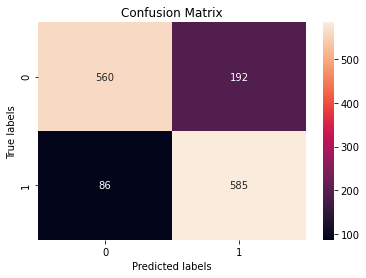

In [215]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt   


cm = confusion_matrix(label, pred, labels=[0,1])

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation
# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['0', '1']); ax.yaxis.set_ticklabels(['0', '1']);

From the above test, ***The training accuracy is 88.79% 
                     The validation accuracy is 80.46%***
                     
The model performed well in training and validation process though we have some mis-predictions. The model performed well for the precision, which is out found predictions, how many are true labels which is relevant, label 1 did the fair job as well. It was around 75%.

For the Recall, which is out of all positives, how many original positives are found. For label 0, around 74% and label 1, 87%.
The confusion matrix is shown above.



## Step 6: Model Inference

The model will be loaded and Model Inference will be made against this model. 

In [216]:
#load weights
path='saved_weights2.pt'
model.load_state_dict(torch.load(path));
model.eval();

#Instantiate the spacy 
import spacy
nlp = spacy.load('en_core_web_sm')


In [229]:
#define a function for prediction
def predict(model, sentence):
    '''Function that gives us prediction of the passed sentence
    Args: model, sentence-a string
    returns: Predictions'''
    sentence = review_to_words(sentence)
    #print(sentence)
    tokenized = [tok.text for tok in nlp.tokenizer(sentence)]  #tokenize the sentence 
    #print(tokenized)
    indexed = [word_dict[t] for t in tokenized]          #convert to integer sequence    
    #print(indexed)
    tensor = torch.LongTensor(indexed).to(device)
    #print(tensor)
    tensor = tensor.unsqueeze(1).T                             #reshape in form of batch,no. of words
    #print(tensor)
    prediction = model(tensor).argmax(dim=1)
    #print(prediction)
    return prediction.item()                          

In [230]:
#Lets use it for predicting the model

x = predict(model, "how the #altright uses  &amp; insecurity to lure men into #whitesupremacy")  
print(x)

1


The model performs well, as it detected the hate spech with the correct label. However, the model needs to be udated every now then with the available data to make the model perform well.

## Load the test dataset and get results

We will now load the test dataset, transform into form we did above step by step. We will then define a predit function to send each sentence and get the results. Finally we will append all the results into the main dataframe and write the file into the csv.

In [221]:
#load the csv file
df_test = pd.read_csv(r'twitter-hate-speech/test_tweets_anuFYb8.csv')

#Apply all the steps we did before training
df_test = df_test.drop(['id'], axis=1)
df_test['tweet'] = df_test['tweet'].apply((lambda x: review_to_words(x)))
df_test['tweet'] = df_test['tweet'].apply(lambda x : ' '.join(replace_words[word] if word in replace_words else word for word in x.split()))
df_test['tweet'] = df_test['tweet'].apply(lambda x: x.replace('user',''))

#print the dataframe
df_test.head()

,tweet
0,studiolife aislife requires passion dedication...
1,white supremacists want everyone to see the n...
2,safe ways to heal your acne altwaystoheal heal...
3,is the hp and the cursed child book up for res...
4,3rd bihday to my amazing hilarious nephew eli ...


In [226]:
df_test.describe()

,tweet
count,17197
unique,16049
top,model i love u take with u all the time in ur
freq,170


In [231]:
#define a function for prediction
def predict_fn(model, sentence):
    '''Function that gives us prediction of the passed sentence
    Args: model, sentence-a string
    returns: Predictions'''
    tokenized = [tok.text for tok in nlp.tokenizer(sentence)]  #tokenize the sentence 
    indexed = [word_dict[t] for t in tokenized]          #convert to integer sequence    
    tensor = torch.LongTensor(indexed).to(device)
    tensor = tensor.unsqueeze(1).T                             #reshape in form of batch,no. of words
    prediction = model(tensor).argmax(dim=1)
    #print(prediction)
    return prediction.item()  

In [234]:
#we will now make a list of predictions 
label_test = [predict_fn(model, df_test['tweet'][ind]) for ind in df_test.index]

print(label_test)

[0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 

In [238]:
#convert the list into the dataframe and assign it to column called label into the test dataframe
df_test['label'] = pd.DataFrame(label_test)

#display the results
df_test.head()

,tweet,label
0,studiolife aislife requires passion dedication...,0
1,white supremacists want everyone to see the n...,1
2,safe ways to heal your acne altwaystoheal heal...,0
3,is the hp and the cursed child book up for res...,1
4,3rd bihday to my amazing hilarious nephew eli ...,0


In [237]:
#write the file into the csv
df_test.to_csv(r'twitter-hate-speech/test_results.csv')

0    11710
1     5487
Name: label, dtype: int64


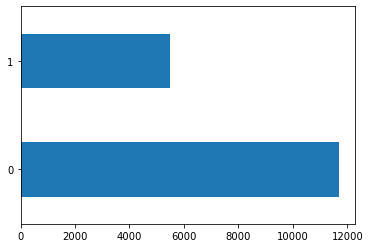

In [241]:
#a simple visualization to show the prediction
df_test.label.value_counts().plot(kind='barh')
print(df_test.label.value_counts())

## Amazon SageMaker training and Deployment

We will do the same procedure by the above, write all functions into the train.py file in the train folder, modules into the module.py file in the same, all the datasets in the same file and instantiate the sagemaker. 

Also, the datasets will be uploaded into the S3 bucket for the training and validation. The trained model will be deployed on the sagemaker. We will not go much detail into the inference at this part, because the part is finished already with the tested dataset above. We will delete all the endpoints at the end

**Amazon Sagemaker Training**

We need to feed the build_vocab and train loop on the separate .py file and code the sequences in the correct order and when if __name__=='__main__': called, the file is excuted from that part. For the reference, the file train.py is loaded below

In [99]:
!pygmentize train/train.py

import torch
from torch import nn
from torch.autograd import Variable
import torch.nn.functional as F
import random, tqdm, sys, math, gzip
# from torchtext import data, datasets, vocab
from torchtext.legacy import data, datasets, vocab
import numpy as np
from model import CTransformer
import argparse
import json
import os
import pickle
import sys
#import sagemaker_containers
import pandas as pd
import torch
import torch.optim as optim
import torch.utils.data
import spacy
from spacy.cli.download import download
download('en_core_web_sm')
spacy.load('en_core_web_sm')

def build_vocab(file_path):
    #Reproducing same results
    SEED = 2019

    #Torch
    torch.manual_seed(SEED)

    TEXT = data.Field(tokenize='spacy',lower=True, include_lengths=True, batch_first=True)
    LABEL = data.LabelField(batch_first=True)
    fields = [(None,None),('tweet', TEXT),('label', LABEL)]

    training_data=data.TabularDataset(path = file_path,format = 'csv',fields = fields,skip_header = True)
    trai

    parser.add_argument("-V", "--vocab-size", dest="vocab_size",
                        help="Number of words in the vocabulary.",
                        default=50000, type=int)

    parser.add_argument("-M", "--max", dest="max_length",
                        help="Max sequence length. Longer sequences are clipped (-1 for no limit).",
                        default=512, type=int)

    parser.add_argument("-H", "--heads", dest="num_heads",
                        help="Number of attention heads.",
                        default=8, type=int)

    parser.add_argument("-d", "--depth", dest="depth",
                        help="Depth of the network (nr. of self-attention layers)",
                        default=6, type=int)

    parser.add_argument("-r", "--random-seed",
                        dest="seed",
                        help="RNG seed. Negative for random",
                        default=1, type=int)

    parser.add_argument("--lr-warmup",
                        dest="l

In [128]:
#import sagemaker
import sagemaker

#Create a seesion and execution role
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()

In [129]:
#Deifne a bucket directory to send in the file for training

bucket = sagemaker_session.default_bucket()
prefix = 'sagemaker/hatespeech_twitter'

In [130]:
#upload the training fle to S3 bucket

input_data = sagemaker_session.upload_data(path=r'/home/ec2-user/SageMaker/train/df.csv', 
                                           bucket=bucket, 
                                           key_prefix=prefix
                                           )

In [131]:
#Instaniate the sagemaker pytorch container and pass in the hyper parameters and other parameters

from sagemaker.pytorch import PyTorch

estimator = PyTorch(entry_point="train.py",
                    source_dir="train",
                    role=role,
                    instance_count=1,
                    instance_type='ml.m4.xlarge',
                    py_version='py36',
                    framework_version='1.8.0',
                    hyperparameters={
                        'epochs': 10,
                        #'batch_size':4
                    })

In [132]:
estimator.fit({'training': input_data})

2021-08-19 06:31:48 Starting - Starting the training job...
2021-08-19 06:32:12 Starting - Launching requested ML instancesProfilerReport-1629354706: InProgress
......
2021-08-19 06:33:19 Starting - Preparing the instances for training...............
2021-08-19 06:35:44 Downloading - Downloading input data
2021-08-19 06:35:44 Training - Downloading the training image...
2021-08-19 06:36:13 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2021-08-19 06:36:06,170 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2021-08-19 06:36:06,173 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2021-08-19 06:36:06,192 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2021-08-19 06:36:07,635 sagemaker_pytorch_container.training INFO     Invoking user training 

#033✔ Download and installation successful#033
You can now load the package via spacy.load('en_core_web_sm')
ARGS Namespace(batch_size=4, current_host='algo-1', data_dir='/opt/ml/input/data/training', depth=6, embedding_size=128, epochs=10, final=False, gradient_clipping=1.0, hosts=['algo-1'], lr=0.0001, lr_warmup=10000, max_length=512, max_pool=False, model_dir='/opt/ml/model', num_gpus=0, num_heads=8, seed=1, vocab_size=50000)
Using device cpu.
['train.py', 'requirements.txt', 'test.csv', 'df.csv', 'model.py', 'valid.csv', '.ipynb_checkpoints', 'train.csv']
/opt/ml/code
 epoch 0
classification/train-loss 0.9302907586097717 64
classification/train-loss 0.6300274133682251 128
classification/train-loss 0.5771304368972778 192
classification/train-loss 0.9490734934806824 256
classification/train-loss 0.7073699831962585 320
classification/train-loss 0.753623902797699 384
classification/train-loss 0.7993888854980469 448
classification/train-loss 0.7244541645050049 512
classification/train-l

classification/train-loss 0.5336697697639465 5683
classification/train-loss 0.464748352766037 5747
classification/train-loss 0.5403576493263245 5811
classification/train-loss 0.5876447558403015 5875
classification/train-loss 0.45023712515830994 5939
classification/train-loss 0.5720333456993103 6003
classification/train-loss 0.6609272360801697 6067
classification/train-loss 0.4895853102207184 6131
classification/train-loss 0.5254914164543152 6195
classification/train-loss 0.5509509444236755 6259
classification/train-loss 0.5287621021270752 6323
classification/train-loss 0.4237419664859772 6387
classification/train-loss 0.5026645064353943 6451
classification/train-loss 0.5811759829521179 6515
classification/train-loss 0.6033217906951904 6579
classification/train-loss 0.44300785660743713 6643
classification/train-loss 0.5527408123016357 6707
classification/train-loss 0.4928828179836273 6771
classification/train-loss 0.5620250701904297 6835
classification/train-loss 0.4479620158672333 6899

classification/train-loss 0.35929253697395325 16460
classification/train-loss 0.38334745168685913 16524
classification/train-loss 0.3830803632736206 16588
classification/train-loss 0.33240920305252075 16652
classification/train-loss 0.3853560984134674 16716
classification/train-loss 0.47416672110557556 16780
classification/train-loss 0.420382559299469 16844
classification/train-loss 0.35123565793037415 16908
classification/train-loss 0.44311365485191345 16972
classification/train-loss 0.3806411027908325 17036
classification/train-loss 0.38709521293640137 17100
classification/train-loss 0.3918030858039856 17164
classification/train-loss 0.35779911279678345 17228
classification/train-loss 0.3158093988895416 17292
classification/train-loss 0.3983611762523651 17356
classification/train-loss 0.36888691782951355 17420
classification/train-loss 0.32049867510795593 17484
classification/train-loss 0.38501235842704773 17548
classification/train-loss 0.31017884612083435 17612
classification/train

classification/train-loss 0.323200523853302 28069
classification/train-loss 0.3367713987827301 28133
-- test validation accuracy 79.45117833149682
-- test validation accuracy 78.35171213000581

 epoch 7
classification/train-loss 0.32624199986457825 28197
classification/train-loss 0.21396131813526154 28261
classification/train-loss 0.1687806248664856 28325
classification/train-loss 0.23077288269996643 28389
classification/train-loss 0.21372638642787933 28453
classification/train-loss 0.2571708559989929 28517
classification/train-loss 0.29028478264808655 28581
classification/train-loss 0.2743845283985138 28645
classification/train-loss 0.29934966564178467 28709
classification/train-loss 0.21344560384750366 28773
classification/train-loss 0.2922583222389221 28837
classification/train-loss 0.4297371804714203 28901
classification/train-loss 0.3128012716770172 28965
classification/train-loss 0.204390749335289 29029
classification/train-loss 0.2638189196586609 29093
classification/train-loss 


2021-08-19 06:42:55 Uploading - Uploading generated training model
2021-08-19 06:42:55 Completed - Training job completed
Training seconds: 444
Billable seconds: 444


In [133]:
#Deploy the model using estimator.deploy

predictor = estimator.deploy(initial_instance_count = 1, instance_type = 'ml.m4.xlarge')

-------------------!

With the SageMaker training, we are able to achieve the training accuracy of 83.075% and test validation accuracy of 78.46%. The results are same more or less with the one we have done it locally.

In [186]:
#to delete the end_point.
predictor.delete_endpoint()